# Import

In [9]:
import time
import torch
import random
import numpy as np
import pandas as pd
from fsspec.compression import unzip
from matplotlib import pyplot as plt, ticker
from sklearn.cluster import KMeans, DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, accuracy_score, \
    precision_score, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.svm import OneClassSVM
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn.functional as F

# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Task 1: Dataset Characterization and Preprocessing

## What are your dataset characteristics? How are your attack labels and binary_label distributed?

In [10]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

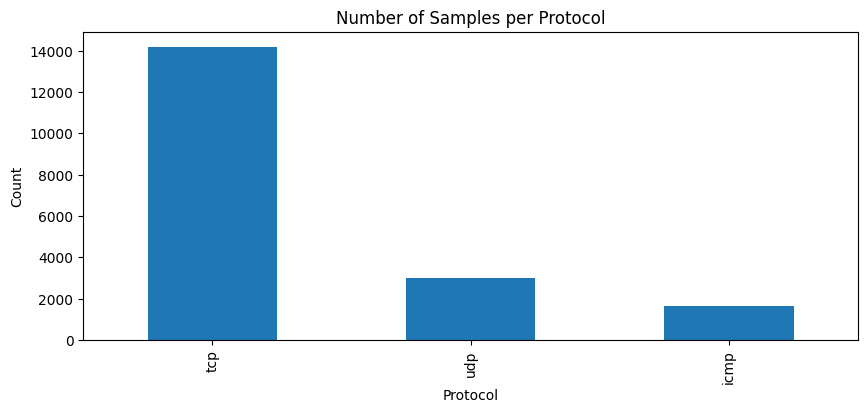

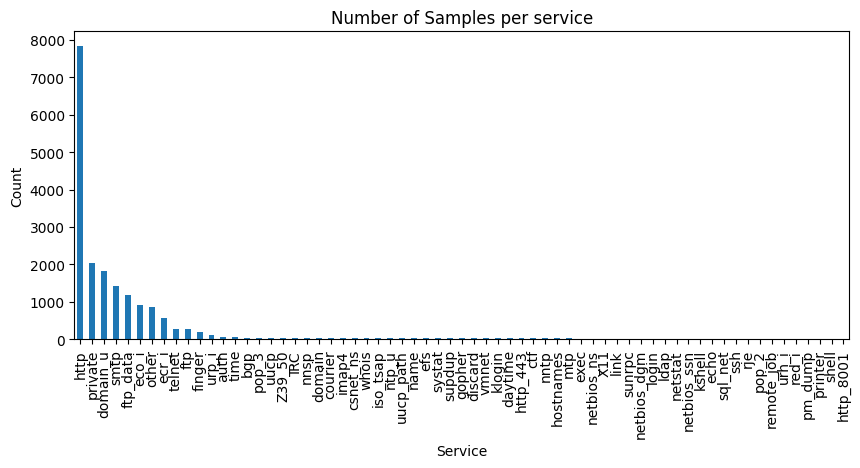

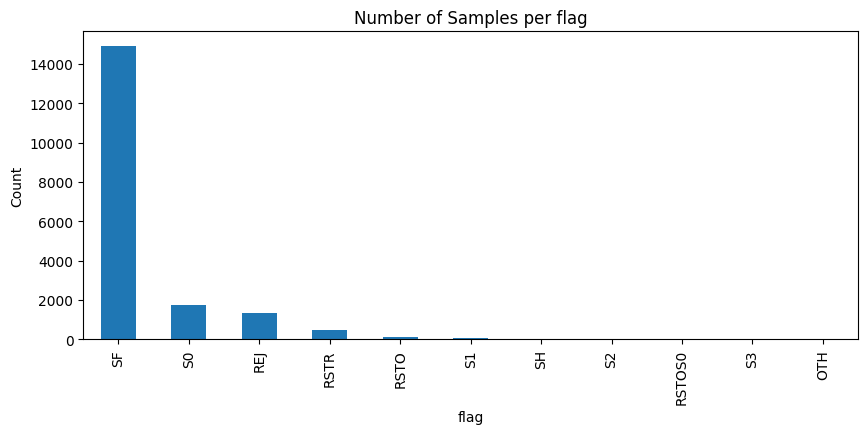

In [11]:
train_data["protocol_type"].value_counts().plot(kind="bar", figsize=(10, 4))
plt.title("Number of Samples per Protocol")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_data["service"].value_counts().plot(kind="bar", figsize=(10, 4))
plt.title("Number of Samples per service")
plt.xlabel("Service")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_data["flag"].value_counts().plot(kind="bar", figsize=(10, 4))
plt.title("Number of Samples per flag")
plt.xlabel("flag")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

## How are your attack labels and binary_label distributed?

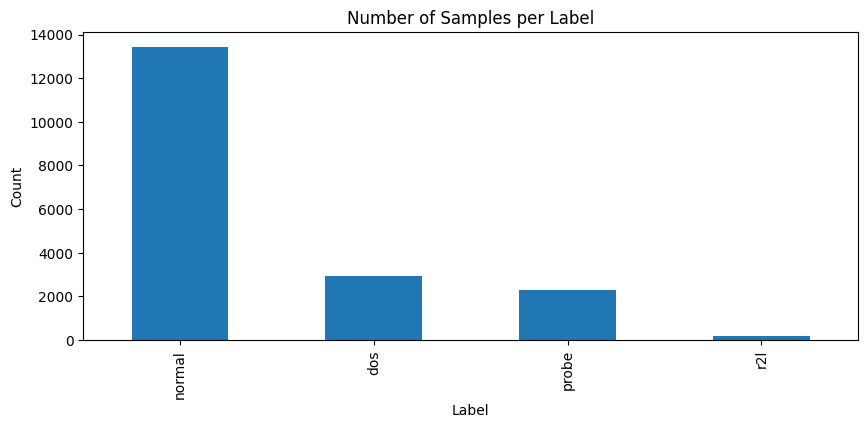

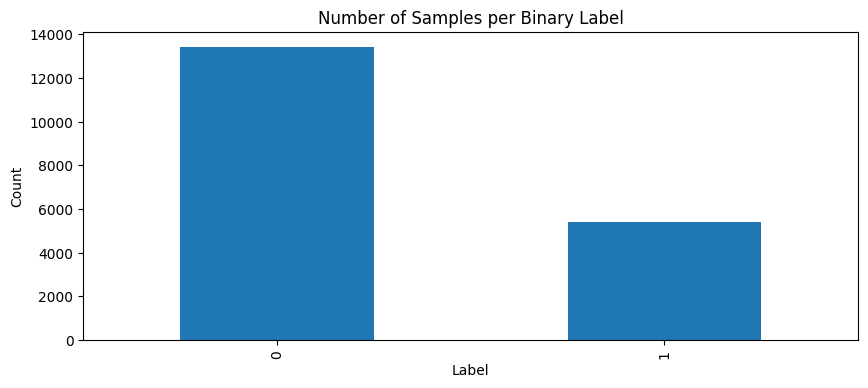

Percentage of normal samples: 71.41  
Percentage of anomalies samples: 28.59


In [12]:
train_data["label"].value_counts().plot(kind="bar", figsize=(10, 4))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_data["binary_label"].value_counts().plot(kind="bar", figsize=(10, 4))
plt.title("Number of Samples per Binary Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

normal_samples = train_data[train_data["binary_label"] == 0].shape[0]
anomalies_samples = train_data[train_data["binary_label"] == 1].shape[0]
print(f"Percentage of normal samples: {(normal_samples / train_data.shape[0]) * 100:.2f}  \nPercentage of anomalies samples: {(anomalies_samples / train_data.shape[0]) * 100:.2f}")

##  How many categorical and numerical attributes do you have?

In [13]:
# Get numerical and categorical attributes
numerical_attributes = train_data.select_dtypes(include=[np.number])
categorical_attributes = train_data.select_dtypes(exclude=[np.number])
print(f"There are {numerical_attributes.shape[1]} numerical attributes and {categorical_attributes.shape[1]} categorical attributes")

There are 39 numerical attributes and 4 categorical attributes


In [14]:
train_data.nunique()

duration                        750
protocol_type                     3
service                          65
flag                             11
src_bytes                      1657
dst_bytes                      3901
land                              2
wrong_fragment                    3
urgent                            1
hot                              21
num_failed_logins                 5
logged_in                         2
num_compromised                  27
root_shell                        2
su_attempted                      3
num_root                         25
num_file_creations               19
num_shells                        2
num_access_files                  7
num_outbound_cmds                 1
is_host_login                     1
is_guest_login                    2
count                           466
srv_count                       414
serror_rate                      65
srv_serror_rate                  43
rerror_rate                      72
srv_rerror_rate             

## Preprocessing

### Drop useless features

In [15]:
# We drop these features because: urgent, num_outbound_cmds, is_host_login are always 0; land is 1 only for one entry. So these features do not give any information to the model
features_to_drop = ["urgent", "num_outbound_cmds", "is_host_login", "land"]
train_data = train_data.drop(columns=features_to_drop)
test_data = test_data.drop(columns=features_to_drop)

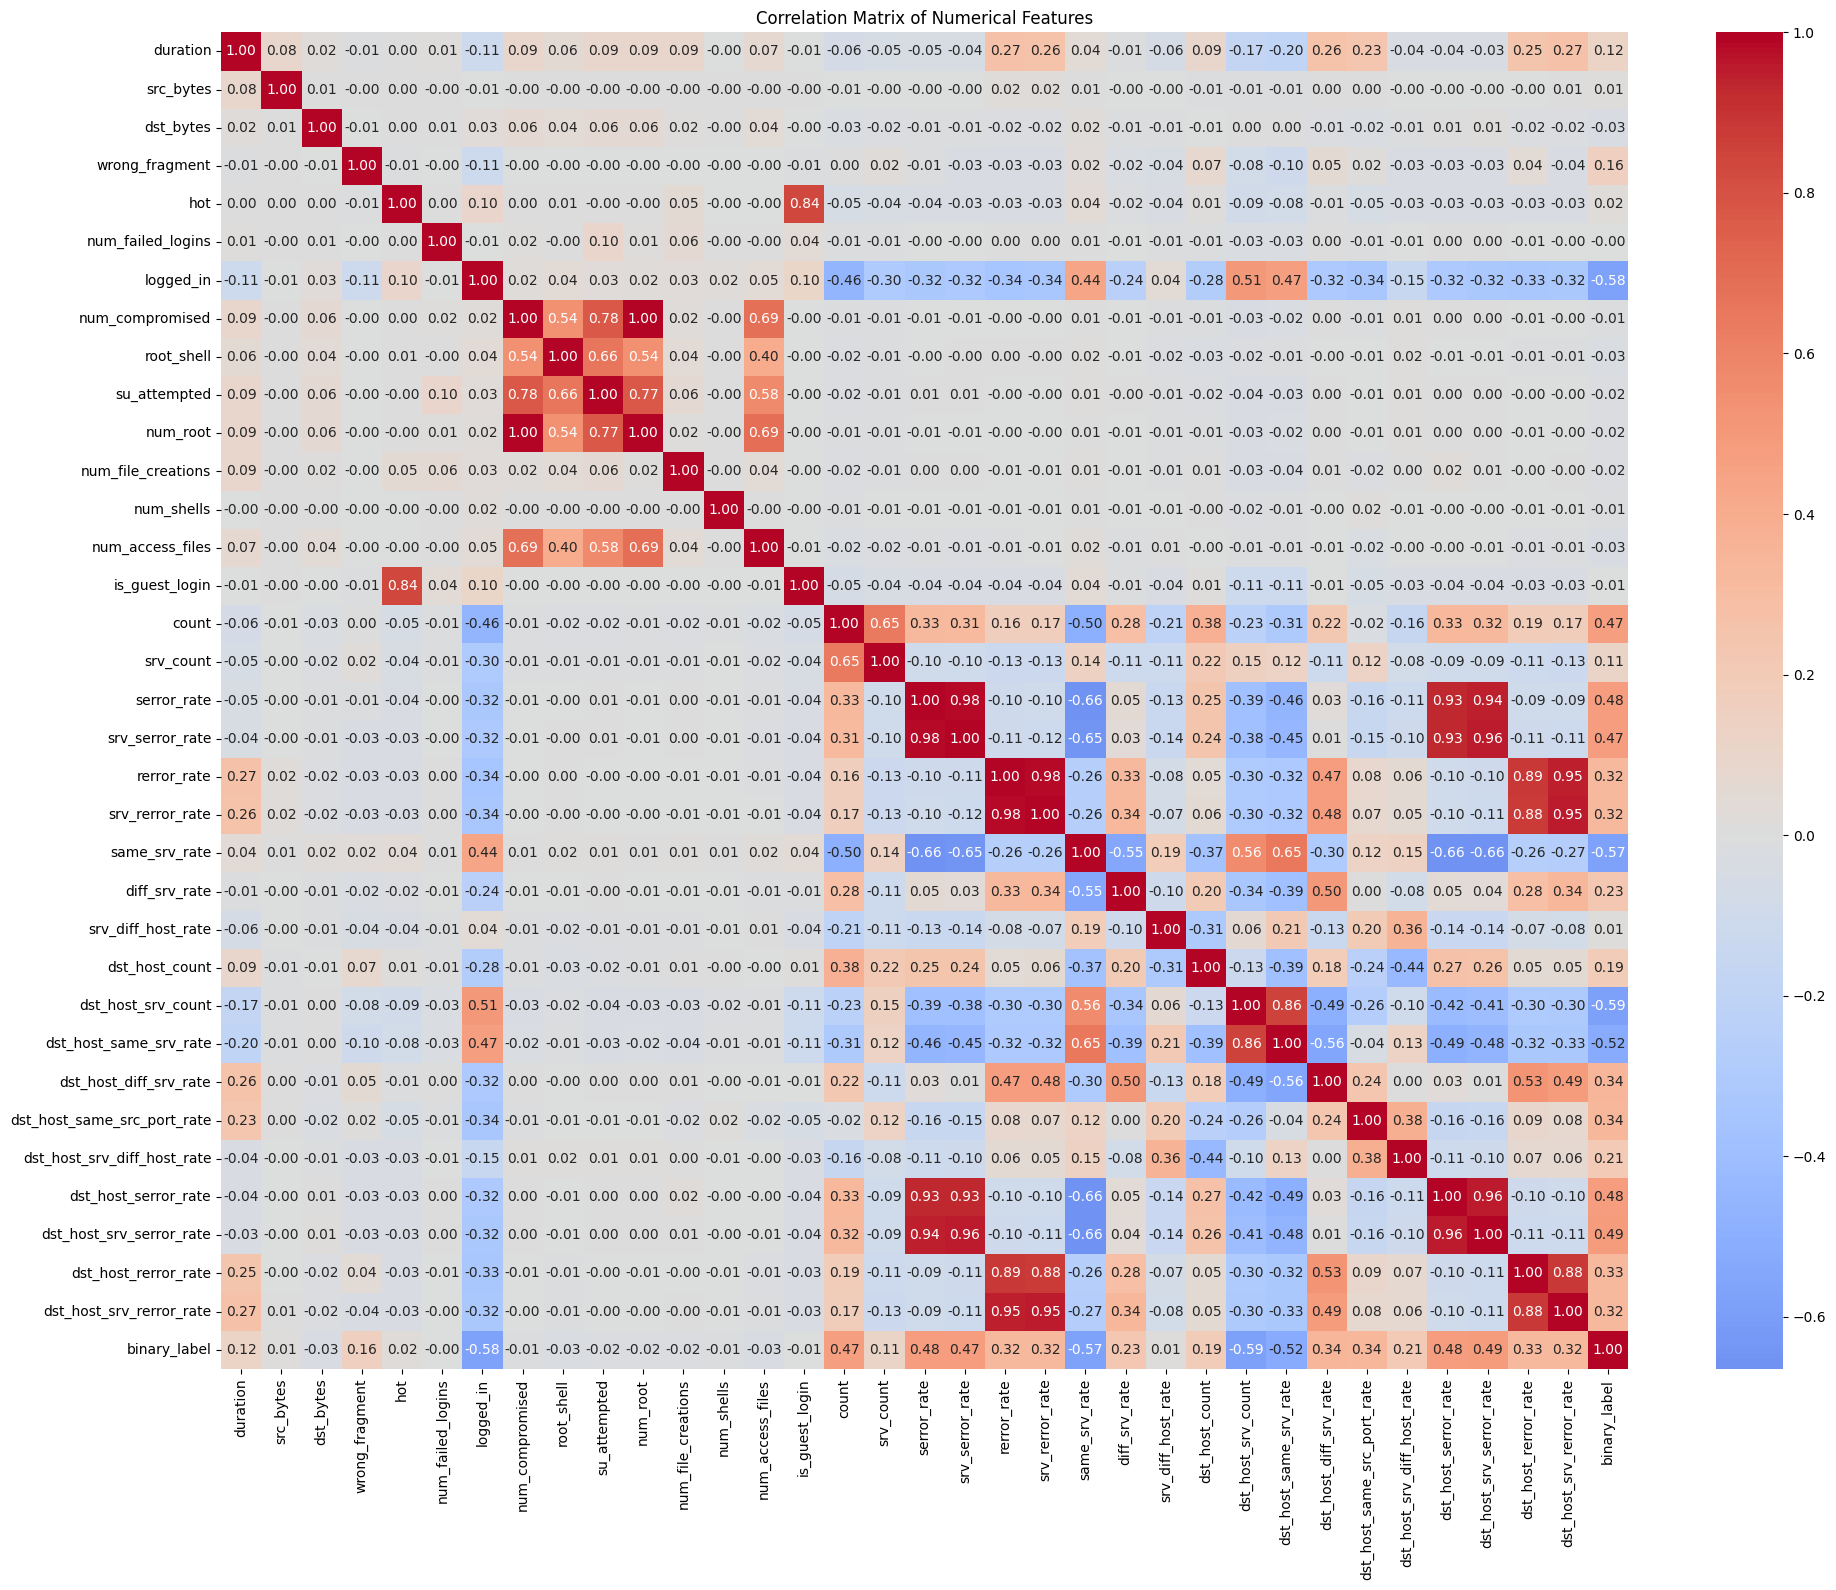

In [16]:
# Calculate correlation matrix for numerical features
correlation_matrix = train_data.select_dtypes(include=[np.number]).corr()

# Create heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()
plt.close()

In [929]:
# Deleting the ones with |p|>=0.8. We try to limit curse of dimensionality

#train_data = train_data.drop(['hot', 'serror_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate', 'rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'dst_host_same_srv_rate'], axis=1)
#test_data = test_data.drop(['hot', 'serror_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate', 'rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'dst_host_same_srv_rate'], axis=1)

In [17]:
# Removing duplicates
previous_train_length = len(train_data)
previous_test_length = len(test_data)
test_data = test_data.drop_duplicates()
train_data = train_data.drop_duplicates()
print(f"Removed {previous_train_length - len(train_data)} duplicates from training set")
print(f"Removed {previous_test_length - len(test_data)} duplicates from test set")

# Remove missing values
previous_train_length = len(train_data)
previous_test_length = len(test_data)
test_data = test_data.dropna()
train_data = train_data.dropna()
print(f"Removed {previous_train_length - len(train_data)} missing values from training set")
print(f"Removed {previous_test_length - len(test_data)} missing values from test set")

# Remove infinite and negative values
numerical_attributes_train = train_data.select_dtypes(include=[np.number])
numerical_attributes_test = test_data.select_dtypes(include=[np.number])
previous_train_length = len(numerical_attributes_train)
previous_test_length = len(numerical_attributes_test)
numerical_attributes_train = train_data[(numerical_attributes.iloc[:, :-2] >= 0).all(axis=1) & np.isfinite(numerical_attributes.iloc[:, :-1]).all(axis=1)]
numerical_attributes_test = test_data[(numerical_attributes_test.iloc[:, :-2] >= 0).all(axis=1) & np.isfinite(numerical_attributes_test.iloc[:, :-1]).all(axis=1)]
actual_length = len(numerical_attributes)
print(f"Removed {previous_train_length - len(numerical_attributes_train)} infinite and negative values from training set")
print(f"Removed {previous_test_length - len(numerical_attributes_test)} infinite and negative values from test set")

Removed 0 duplicates from training set
Removed 0 duplicates from test set
Removed 0 missing values from training set
Removed 0 missing values from test set
Removed 0 infinite and negative values from training set
Removed 0 infinite and negative values from test set


### Reduce the number of possible categories for "flag" and "service" categorical attributes

In [18]:
service_percentage = train_data['service'].value_counts(normalize=True) * 100  # Get percentage of service values
flag_percentage = train_data['flag'].value_counts(normalize=True) * 100  # Get percentage of flag values

services_over_1pct = service_percentage[service_percentage > 1]  # Get services with percentage > 1
flags_over_1pct = flag_percentage[flag_percentage > 1]  # Get flags with percentage > 1
print(services_over_1pct)
print(flags_over_1pct)

allowed_services = ['http', 'private', 'domain_u', 'smtp', 'ftp_data', 'echo_i', 'ecr_it', 'telnet', 'ftp', 'finger']
allowed_flags = ['SF', 'S0', 'REJ', 'RSTR']

train_data["service"] = train_data["service"].apply(lambda x: x if x in allowed_services else "other")
test_data["service"] = test_data["service"].apply(lambda x: x if x in allowed_services else "other")

train_data["flag"]   = train_data["flag"].apply(lambda x: x if x in allowed_flags else "other")
test_data["flag"] = test_data["flag"].apply(lambda x: x if x in allowed_flags else "other")

service
http        41.585683
private     10.811959
domain_u     9.664914
smtp         7.492964
ftp_data     6.324677
eco_i        4.827147
other        4.540386
ecr_i        3.064096
telnet       1.423185
ftp          1.396633
finger       1.024906
Name: proportion, dtype: float64
flag
SF      79.162020
S0       9.372843
REJ      7.216823
RSTR     2.639265
Name: proportion, dtype: float64


In [19]:
service_percentage_train = train_data['service'].value_counts(normalize=True) * 100  # Get percentage of service values
service_percentage_test = test_data['service'].value_counts(normalize=True) * 100  # Get percentage of service values
flag_percentage_train = train_data['flag'].value_counts(normalize=True) * 100  # Get percentage of flag values
flag_percentage_test = test_data['flag'].value_counts(normalize=True) * 100  # Get percentage of flag values

print("TRAINING SET")
print(service_percentage_train)
print(flag_percentage_train)
print("\nTEST SET")
print(service_percentage_test)
print(flag_percentage_test)

TRAINING SET
service
http        41.585683
other       20.275078
private     10.811959
domain_u     9.664914
smtp         7.492964
ftp_data     6.324677
telnet       1.423185
ftp          1.396633
finger       1.024906
Name: proportion, dtype: float64
flag
SF       79.162020
S0        9.372843
REJ       7.216823
RSTR      2.639265
other     1.609049
Name: proportion, dtype: float64

TEST SET
service
other       44.181256
private     23.498112
http        11.328527
domain_u     9.423275
ftp_data     4.273944
telnet       2.797803
smtp         2.128390
finger       1.390319
ftp          0.978373
Name: proportion, dtype: float64
flag
SF       59.079986
REJ      21.198078
S0       10.298661
other     6.333677
RSTR      3.089598
Name: proportion, dtype: float64


### Split datasets

In [20]:
y = train_data.iloc[:, -1].values   # Get label column

X_train, X_val, y_train, y_val = train_test_split(train_data, y, train_size=0.8, stratify=train_data["label"],random_state=seed)
X_test = test_data
y_test = test_data.iloc[:, -1].values   # Get label column

### Standardization and encoding

In [21]:
#Perform feature normalization and process categorical and numerical features simultaneously

# Set up column groups
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in train_data.columns if col not in categorical_cols + ignore_cols]

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# Fit on training, transform all splits
X_train_transformed = preprocessor.fit_transform(pd.DataFrame(X_train))
X_val_transformed = preprocessor.transform(pd.DataFrame(X_val))
X_test_transformed = preprocessor.transform(pd.DataFrame(X_test))

# Get transformed feature names and make DataFrames
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_val_preprocessed   = pd.DataFrame(X_val_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Restore the labels
df_train_preprocessed["label"] = list(X_train["label"])
df_val_preprocessed["label"]   = list(X_val["label"])
df_test_preprocessed["label"]  = list(X_test["label"])

df_train_preprocessed["binary_label"] = list(X_train["binary_label"])
df_val_preprocessed["binary_label"]   = list(X_val["binary_label"])
df_test_preprocessed["binary_label"]  = list(X_test["binary_label"])

## Study your data from a domain expert perspective

### Mean heatmap

In [22]:
feature_mean_per_label = pd.concat([df_train_preprocessed.select_dtypes(include=[np.number]), df_train_preprocessed['label']],axis=1).groupby(['label']).mean()
feature_mean_per_label.style.format("{:.3f}").background_gradient(cmap='Blues')

### Standard deviation heatmap

In [23]:
feature_mean_per_label = pd.concat(
    [df_train_preprocessed.select_dtypes(include=[np.number]), df_train_preprocessed['label']], axis=1).groupby(['label']).std()
feature_mean_per_label.style.format("{:.3f}").background_gradient(cmap='Blues')

### Median heatmap

In [24]:
feature_mean_per_label = pd.concat([df_train_preprocessed.select_dtypes(include=[np.number]), df_train_preprocessed['label']], axis=1).groupby(['label']).median()
feature_mean_per_label.style.format("{:.3f}").background_gradient(cmap='Blues')

# Task 2: Shallow Anomaly Detection - Supervised vs Unsupervised

In [25]:
def plot_confusion_matrix(y_binary, y_pred, methodology, data_name):

    print(f"\nClassification Report ({methodology} vs Ground Truth):")
    print(classification_report(y_binary, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
    plt.title('Confusion Matrix %s with %s'%(data_name,methodology))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

In [26]:
df_train_normal_only = df_train_preprocessed[df_train_preprocessed["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train_preprocessed.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train_preprocessed['label'])
y_train = list(df_train_preprocessed['binary_label'])

X_val = df_val_preprocessed.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val_preprocessed['label'])
y_val = list(df_val_preprocessed['binary_label'])

X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test_preprocessed['label'])
y_test = list(df_test_preprocessed['binary_label'])

## One-Class SVM with Normal data only

### Default parameters


Classification Report (O-SVM trained on normal data and default params vs Ground Truth):
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     10758
           1       0.44      0.99      0.61      4306

    accuracy                           0.64     15064
   macro avg       0.72      0.74      0.64     15064
weighted avg       0.83      0.64      0.65     15064



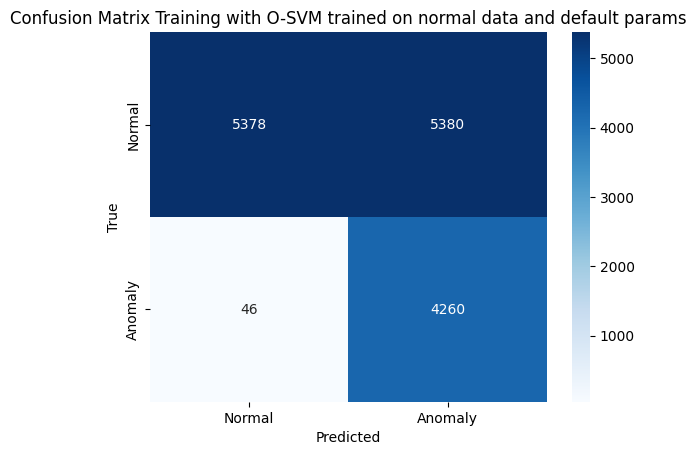


Classification Report (O-SVM trained on normal data and default params vs Ground Truth):
              precision    recall  f1-score   support

           0       0.99      0.50      0.67      2690
           1       0.44      0.99      0.61      1077

    accuracy                           0.64      3767
   macro avg       0.72      0.75      0.64      3767
weighted avg       0.83      0.64      0.65      3767



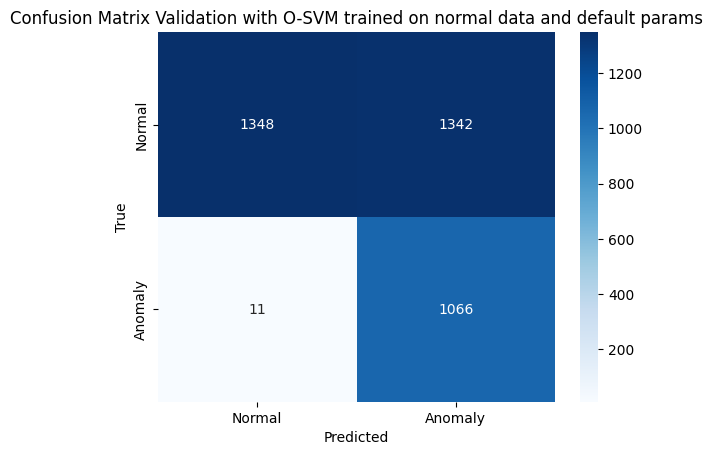


Classification Report (O-SVM trained on normal data and default params vs Ground Truth):
              precision    recall  f1-score   support

           0       0.92      0.08      0.15      2152
           1       0.65      1.00      0.79      3674

    accuracy                           0.66      5826
   macro avg       0.78      0.54      0.47      5826
weighted avg       0.75      0.66      0.55      5826



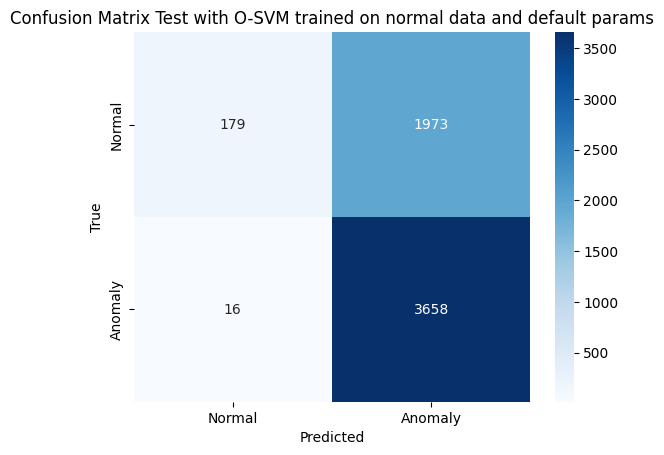

In [27]:
# Fit One-Class SVM
ocsvm_normal_only = OneClassSVM(kernel='rbf')
ocsvm_normal_only.fit(X_train_normal_only)

# Inference
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm_normal_only.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

y_val_pred = ocsvm_normal_only.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm_normal_only.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM trained on normal data and default params", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM trained on normal data and default params", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM trained on normal data and default params", "Test")

### Parameters tuning

In [28]:
nu_values = [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005]
gamma_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 'auto', 'scale']
best_f1 = 0
best_pars = None

for pars in ParameterGrid({'nu':nu_values, 'gamma':gamma_values}):
    oc = OneClassSVM(kernel='rbf', **pars).fit(X_train_normal_only)

    # predict on validation set (contains normals + attacks)
    y_val_pred = (oc.predict(X_val) == -1).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_pars = pars

print(f"Best params: {best_pars}, best F1: {best_f1:.2f}")

Best params: {'gamma': 0.1, 'nu': 0.001}, best F1: 0.90



Classification Report (O-SVM trained on normal data vs Ground Truth):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10758
           1       0.96      0.87      0.91      4306

    accuracy                           0.95     15064
   macro avg       0.96      0.93      0.94     15064
weighted avg       0.95      0.95      0.95     15064



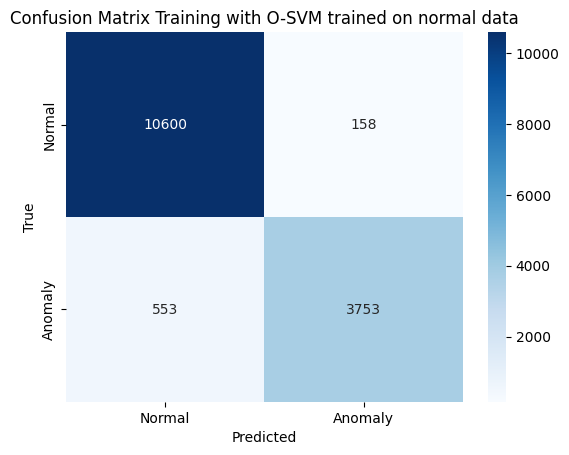


Classification Report (O-SVM trained on normal data vs Ground Truth):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2690
           1       0.93      0.88      0.90      1077

    accuracy                           0.95      3767
   macro avg       0.94      0.93      0.93      3767
weighted avg       0.95      0.95      0.95      3767



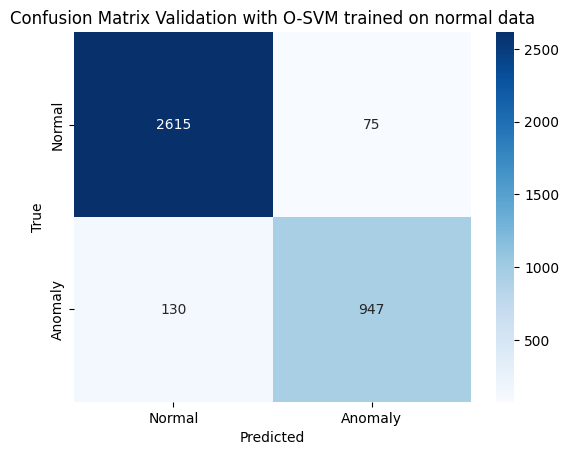


Classification Report (O-SVM trained on normal data vs Ground Truth):
              precision    recall  f1-score   support

           0       0.74      0.64      0.68      2152
           1       0.80      0.87      0.83      3674

    accuracy                           0.78      5826
   macro avg       0.77      0.75      0.76      5826
weighted avg       0.78      0.78      0.78      5826



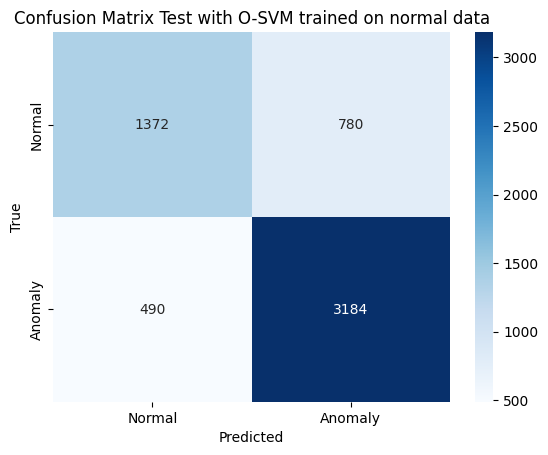

In [29]:
# Fit One-Class SVM
ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma=best_pars['gamma'], nu=best_pars['nu'])
ocsvm_normal_only.fit(X_train_normal_only)

# Inference

y_train_pred = ocsvm_normal_only.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

y_val_pred = ocsvm_normal_only.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm_normal_only.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM trained on normal data", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM trained on normal data", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM trained on normal data", "Test")

## One-Class SVM with All data

In [30]:
normal_samples = df_train_preprocessed[df_train_preprocessed["binary_label"] == 0].shape[0]
anomalies_samples = df_train_preprocessed[df_train_preprocessed["binary_label"] == 1].shape[0]
anomalous_samples_perc = round((anomalies_samples / df_train_preprocessed.shape[0]),2)
print(f"Percentage of normal samples: {(normal_samples / df_train_preprocessed.shape[0]) * 100:.2f}  \nPercentage of anomalies samples: {(anomalies_samples / df_train_preprocessed.shape[0]) * 100:.2f}")

Percentage of normal samples: 71.42  
Percentage of anomalies samples: 28.58


In [31]:
gamma_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 'auto', 'scale']
best_f1 = 0
best_gamma = None

for gamma in gamma_values:
    oc = OneClassSVM(kernel='rbf', nu=anomalous_samples_perc, gamma=gamma).fit(X_train)

    # predict on validation set (contains normals + attacks)
    y_val_pred = (oc.predict(X_val) == -1).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma

print(f"Best gamma: {best_gamma}, best F1: {best_f1:.2f}")

Best gamma: 1e-05, best F1: 0.78



Classification Report (O-SVM trained on entire train set vs Ground Truth):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10758
           1       0.76      0.78      0.77      4306

    accuracy                           0.87     15064
   macro avg       0.84      0.84      0.84     15064
weighted avg       0.87      0.87      0.87     15064



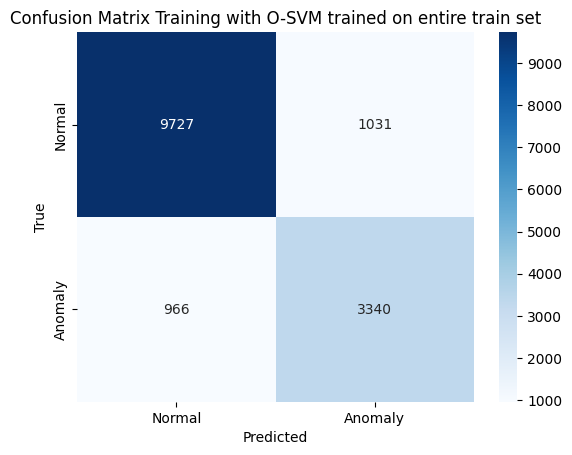


Classification Report (O-SVM trained on entire train set vs Ground Truth):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2690
           1       0.77      0.79      0.78      1077

    accuracy                           0.87      3767
   macro avg       0.84      0.85      0.84      3767
weighted avg       0.87      0.87      0.87      3767



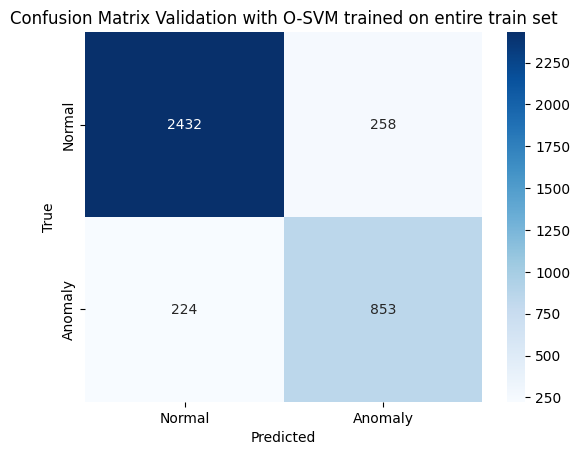


Classification Report (O-SVM trained on entire train set vs Ground Truth):
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      2152
           1       0.80      0.77      0.79      3674

    accuracy                           0.74      5826
   macro avg       0.72      0.72      0.72      5826
weighted avg       0.74      0.74      0.74      5826



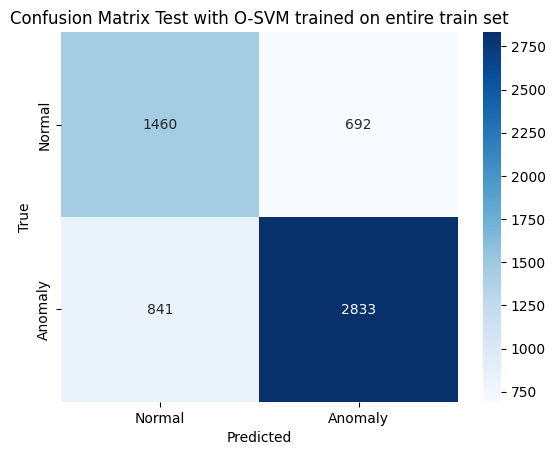

In [32]:
# Fit One-Class SVM
ocsvm_all_data = OneClassSVM(kernel='rbf', gamma=best_gamma, nu=anomalous_samples_perc)
ocsvm_all_data.fit(X_train)

# Inference
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm_all_data.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

y_val_pred = ocsvm_all_data.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm_all_data.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM trained on entire train set", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM trained on entire train set", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM trained on entire train set", "Test")

## One-Class SVM with normal traffic and some anomalies


Trying anomaly percentage: 0

Classification Report (O-SVM trained with normal traffic and 0% anomalies vs Ground Truth):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10758
           1       0.96      0.87      0.91      4306

    accuracy                           0.95     15064
   macro avg       0.96      0.93      0.94     15064
weighted avg       0.95      0.95      0.95     15064



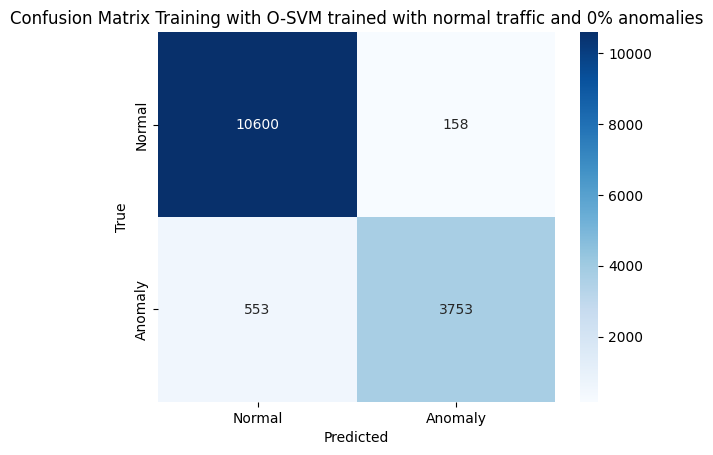


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2690
           1       0.93      0.88      0.90      1077

    accuracy                           0.95      3767
   macro avg       0.94      0.93      0.93      3767
weighted avg       0.95      0.95      0.95      3767



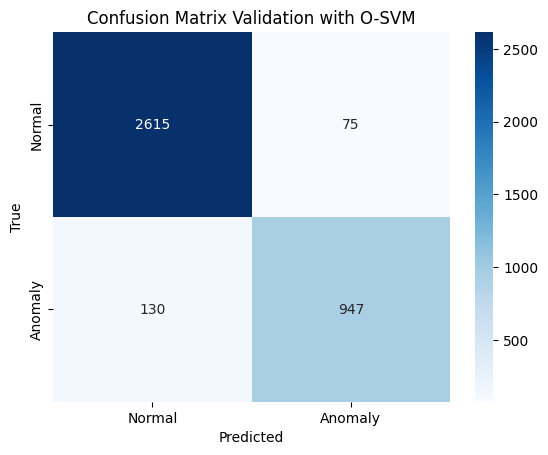


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.74      0.64      0.68      2152
           1       0.80      0.87      0.83      3674

    accuracy                           0.78      5826
   macro avg       0.77      0.75      0.76      5826
weighted avg       0.78      0.78      0.78      5826



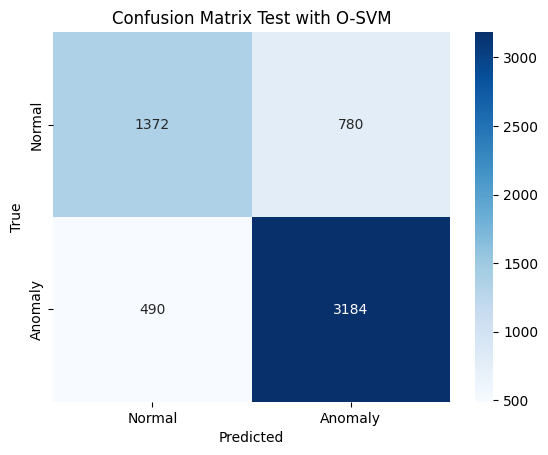


Trying anomaly percentage: 0.1

Classification Report (O-SVM trained with normal traffic and 10.0% anomalies vs Ground Truth):
              precision    recall  f1-score   support

           0       0.78      0.97      0.87     10758
           1       0.83      0.32      0.46      4306

    accuracy                           0.79     15064
   macro avg       0.81      0.65      0.67     15064
weighted avg       0.80      0.79      0.75     15064



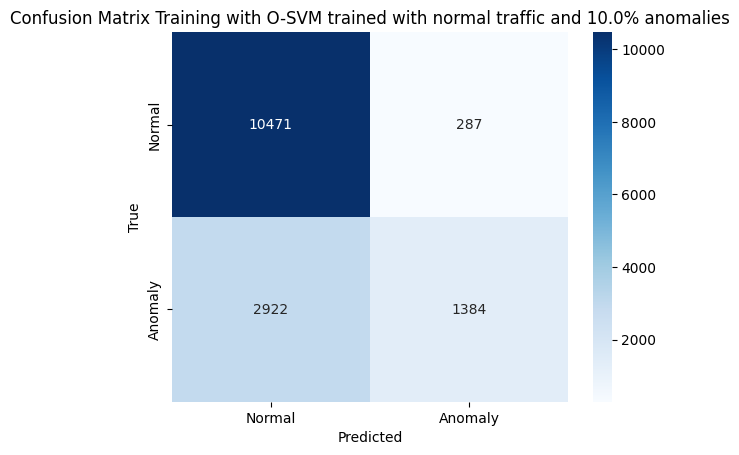


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      2690
           1       0.83      0.31      0.45      1077

    accuracy                           0.78      3767
   macro avg       0.81      0.64      0.66      3767
weighted avg       0.79      0.78      0.75      3767



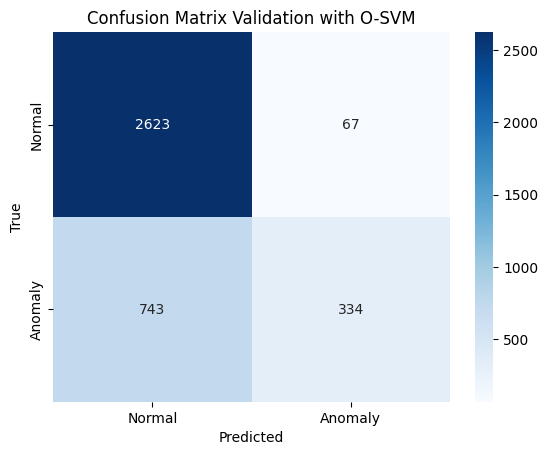


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.39      0.79      0.52      2152
           1       0.68      0.27      0.38      3674

    accuracy                           0.46      5826
   macro avg       0.53      0.53      0.45      5826
weighted avg       0.57      0.46      0.43      5826



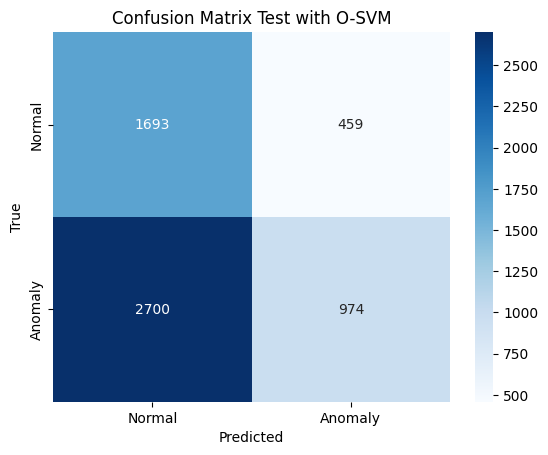


Trying anomaly percentage: 0.2

Classification Report (O-SVM trained with normal traffic and 20.0% anomalies vs Ground Truth):
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     10758
           1       0.82      0.47      0.60      4306

    accuracy                           0.82     15064
   macro avg       0.82      0.71      0.74     15064
weighted avg       0.82      0.82      0.80     15064



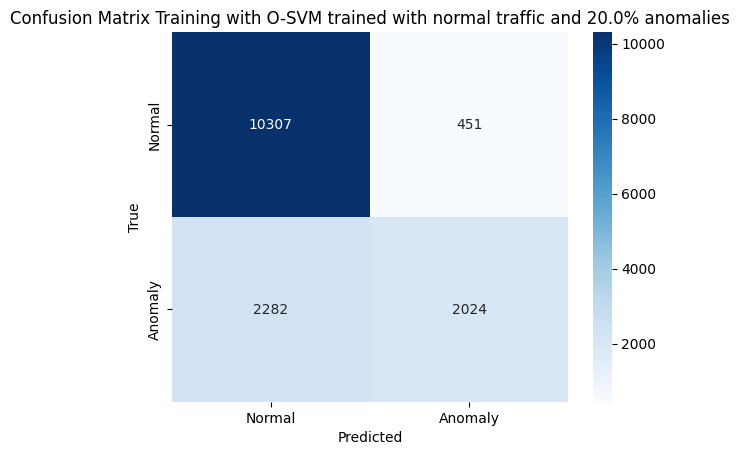


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      2690
           1       0.84      0.47      0.60      1077

    accuracy                           0.82      3767
   macro avg       0.83      0.72      0.74      3767
weighted avg       0.82      0.82      0.80      3767



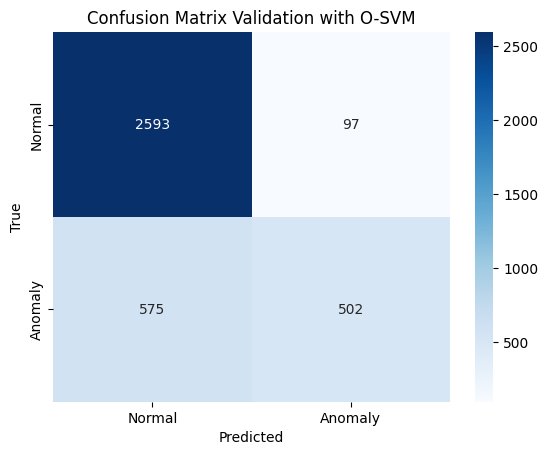


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      2152
           1       0.71      0.36      0.48      3674

    accuracy                           0.50      5826
   macro avg       0.56      0.56      0.50      5826
weighted avg       0.60      0.50      0.50      5826



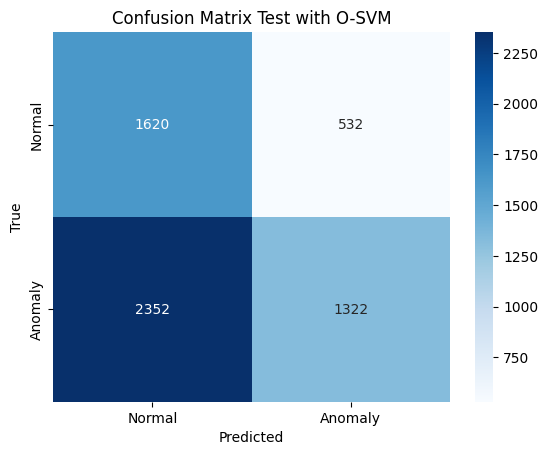


Trying anomaly percentage: 0.5

Classification Report (O-SVM trained with normal traffic and 50.0% anomalies vs Ground Truth):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10758
           1       0.79      0.66      0.72      4306

    accuracy                           0.85     15064
   macro avg       0.83      0.79      0.81     15064
weighted avg       0.85      0.85      0.85     15064



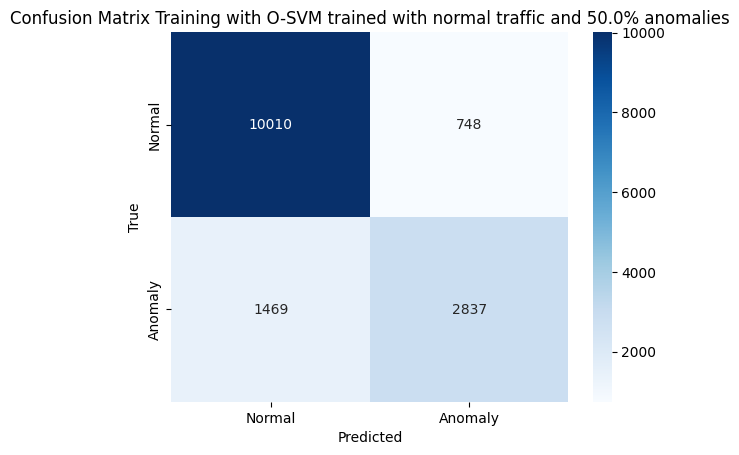


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2690
           1       0.80      0.66      0.72      1077

    accuracy                           0.86      3767
   macro avg       0.84      0.80      0.81      3767
weighted avg       0.85      0.86      0.85      3767



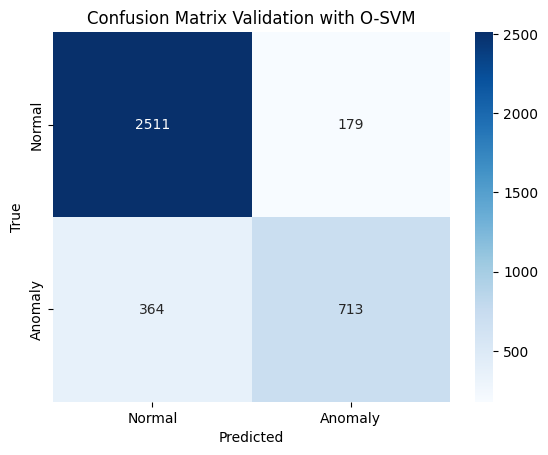


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.49      0.70      0.58      2152
           1       0.77      0.57      0.66      3674

    accuracy                           0.62      5826
   macro avg       0.63      0.64      0.62      5826
weighted avg       0.67      0.62      0.63      5826



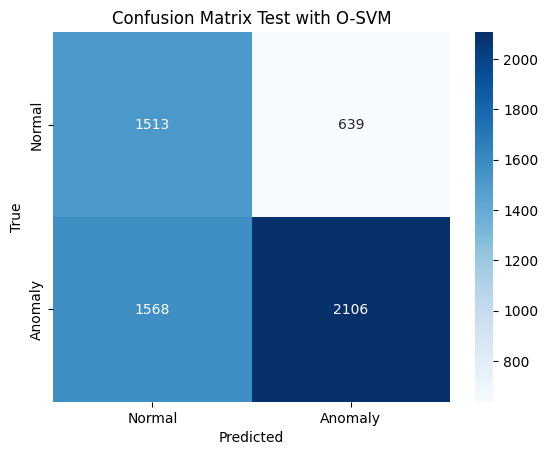


Trying anomaly percentage: 1

Classification Report (O-SVM trained with normal traffic and 100% anomalies vs Ground Truth):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     10758
           1       0.76      0.76      0.76      4306

    accuracy                           0.87     15064
   macro avg       0.83      0.83      0.83     15064
weighted avg       0.87      0.87      0.87     15064



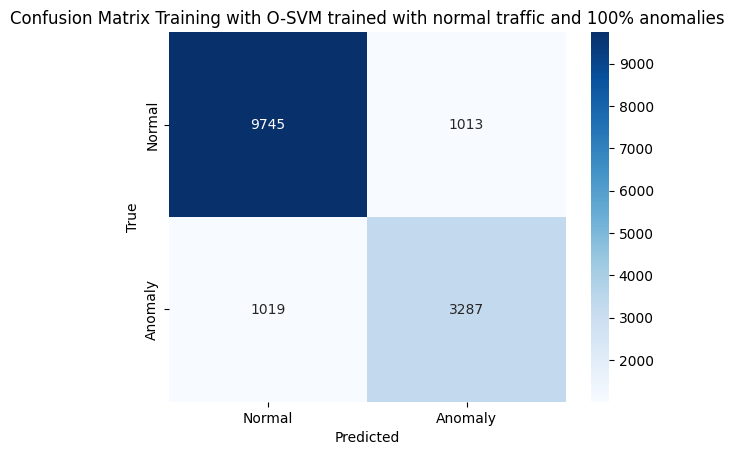


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2690
           1       0.77      0.78      0.77      1077

    accuracy                           0.87      3767
   macro avg       0.84      0.84      0.84      3767
weighted avg       0.87      0.87      0.87      3767



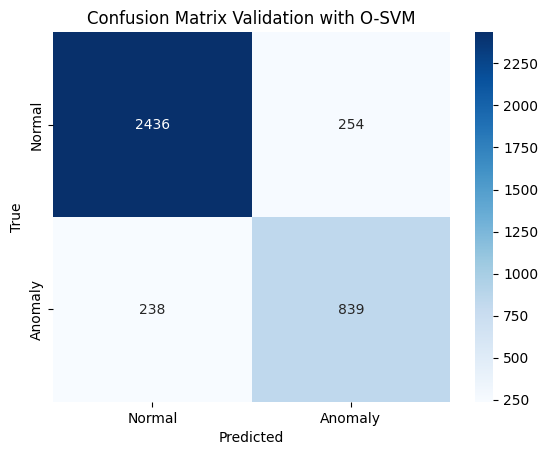


Classification Report (O-SVM vs Ground Truth):
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      2152
           1       0.80      0.76      0.78      3674

    accuracy                           0.73      5826
   macro avg       0.71      0.72      0.72      5826
weighted avg       0.74      0.73      0.73      5826



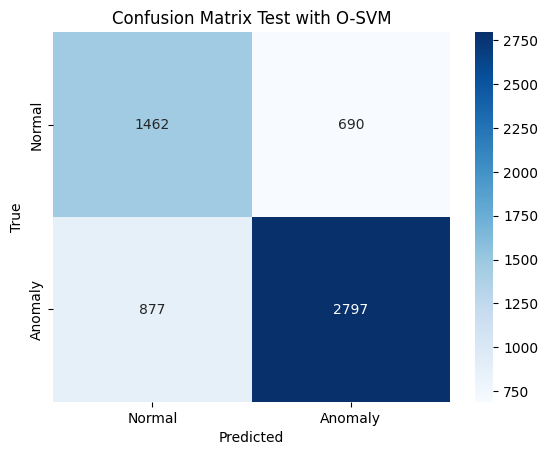

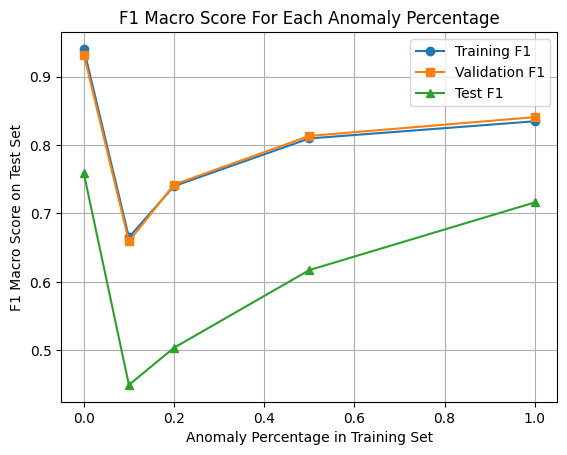

anomaly_percentage  F1 train  F1 val  F1test
0                 0.0      0.94    0.93    0.76
1                 0.1      0.67    0.66    0.45
2                 0.2      0.74    0.74    0.50
3                 0.5      0.81    0.81    0.62
4                 1.0      0.83    0.84    0.72

In [33]:
X_train_only_normal = df_train_preprocessed.drop(columns=['label'])[df_train_preprocessed["binary_label"] == 0]
X_train_only_anomalous = df_train_preprocessed.drop(columns=['label'])[df_train_preprocessed["binary_label"] == 1]

y_train_only_normal = list(X_train_only_normal["binary_label"])
y_train_only_anomalous = list(X_train_only_anomalous["binary_label"])

f1_scores_train = []
f1_scores_validation = []
f1_scores_test = []

for anomalyPercentage in [0, 0.1, 0.2, 0.5, 1]:
    print(f"\nTrying anomaly percentage: {anomalyPercentage}")

    if anomalyPercentage == 0:
        X_train_anomalous_portion = pd.DataFrame()
        y_train_anomalous_portion = []
    elif anomalyPercentage == 1:
        X_train_anomalous_portion = X_train_only_anomalous
        y_train_anomalous_portion = y_train_only_anomalous
    else:
        X_train_anomalous_portion, _, y_train_anomalous_portion, _ = train_test_split(X_train_only_anomalous, y_train_only_anomalous, train_size=anomalyPercentage, stratify=X_train_only_anomalous['binary_label'],random_state=seed)

    X_train = pd.concat([X_train_only_normal, X_train_anomalous_portion], axis=0).drop(columns=['binary_label'])
    y_train = pd.concat([pd.DataFrame(y_train_only_normal),pd.DataFrame(y_train_anomalous_portion)], axis=0).squeeze() # squeeze needed otherwise I cannot do the thing of y_train[y_train==1] because it would not change result set length because will give me NaN for non -matching instead of just not returning them

    if anomalyPercentage == 0:
        nu = 0.001
        gamma = 0.1
    else:
        nu = y_train[y_train==1].shape[0]/y_train.shape[0]
        gamma = 1e-5
    ocsvm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    ocsvm.fit(X_train)

    y_train_pred = ocsvm.predict(df_train_preprocessed.drop(columns=['label', 'binary_label']))
    y_train_pred_binary = (y_train_pred == -1).astype(int)

    X_val = df_val_preprocessed.drop(columns=['label', 'binary_label'])
    X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])

    y_val_pred = ocsvm.predict(X_val)
    y_val_pred_binary = (y_val_pred == -1).astype(int)

    y_test_pred = ocsvm.predict(X_test)
    y_test_pred_binary = (y_test_pred == -1).astype(int)

    plot_confusion_matrix(df_train_preprocessed['binary_label'], y_train_pred_binary, f"O-SVM trained with normal traffic and {anomalyPercentage*100}% anomalies", "Training")
    plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM", "Validation")
    plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM", "Test")

    f1_train = f1_score(df_train_preprocessed['binary_label'], y_train_pred_binary, average='macro')
    f1_val = f1_score(y_val, y_val_pred_binary, average='macro')
    f1_test = f1_score(y_test, y_test_pred_binary, average='macro')

    f1_scores_train.append(f1_train)
    f1_scores_validation.append(f1_val)
    f1_scores_test.append(f1_test)

# Plot f1 scores
plt.figure()
plt.plot([0, 0.1, 0.2, 0.5, 1], f1_scores_train, marker='o', label='Training F1')
plt.plot([0, 0.1, 0.2, 0.5, 1], f1_scores_validation,  marker='s', label='Validation F1')
plt.plot([0, 0.1, 0.2, 0.5, 1], f1_scores_test, marker='^', label='Test F1')

plt.xlabel('Anomaly Percentage in Training Set')
plt.ylabel('F1 Macro Score on Test Set')
plt.title('F1 Macro Score For Each Anomaly Percentage')
plt.grid(True)
plt.legend()
plt.show()

# 1) Build the DataFrame
df_results = pd.DataFrame({
    'anomaly_percentage': [0, 0.1, 0.2, 0.5, 1],
    'F1 train':    f1_scores_train,
    'F1 val':      f1_scores_validation,
    'F1test':     f1_scores_test
}).round(2)

# 2) Print as a Markdown table (works nicely in Jupyter/VSCode etc.)
display(df_results)

# Task 3: Deep Anomaly Detection and Data Representation

In [947]:
# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


## Training and Validating Autoencoder with Normal data only

In [948]:
# Define Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(Autoencoder, self).__init__()

        # Encoder: deeper network, batchnorm, dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, bottleneck_dim)
        )

        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     # bottleneck representation
        x_hat = self.decoder(z) # reconstruction
        return x_hat

    def encode(self, x):
        return self.encoder(x)  # return bottleneck representation

def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    mse = F.mse_loss(x_recon[:, numerical_idx], x[:, numerical_idx])
    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)
    return mse + ce

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:  20%|██        | 20/100 [00:10<00:38,  2.09it/s]

Epoch 20/100, Train Loss: 0.4045, Val Loss: 0.5774


Training:  40%|████      | 40/100 [00:19<00:28,  2.07it/s]

Epoch 40/100, Train Loss: 0.2811, Val Loss: 0.2928


Training:  53%|█████▎    | 53/100 [00:26<00:23,  2.00it/s]

Early stopping triggered after 54 epochs!
Epoch 54/100, Train Loss: 0.2404, Val Loss: 0.2459


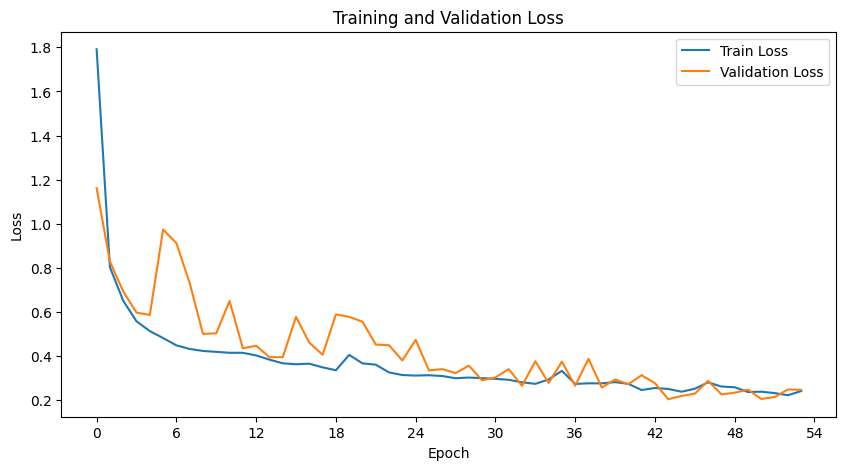

In [949]:
# Filter Normal Data and Split into Training and Validation Sets
# Filter normal data (binary_label == 0) from the training set
X_train_normal = df_train_preprocessed[df_train_preprocessed['binary_label'] == 0].drop(columns=['label', 'binary_label'])
X_val_normal = df_val_preprocessed[df_val_preprocessed['binary_label'] == 0].drop(columns=['label', 'binary_label'])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normal.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_normal.values, dtype=torch.float32).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model
input_dim = X_train_normal.shape[1]
model = Autoencoder(input_dim=input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Starting with a reasonable learning rate

# Define categorical and numerical feature indices
all_columns = df_train_preprocessed.drop(columns=['label', 'binary_label']).columns
categorical_dims = []
for cat in ['protocol_type', 'service', 'flag']:
    cat_cols = [i for i, col in enumerate(all_columns) if col.startswith(cat)]
    if cat_cols:
        categorical_dims.append((min(cat_cols), max(cat_cols) + 1))
numerical_idx = [i for i, col in enumerate(all_columns) if not any(col.startswith(cat) for cat in ['protocol_type', 'service', 'flag'])]

# Train and Validate the Autoencoder with Early Stopping
num_epochs = 100
patience = 10  # Number of epochs to wait for improvement
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
best_model_epoch = 0

train_losses = []
val_losses = []
epochs_no_improvement = 0

for epoch in tqdm(range(num_epochs), desc="Training"):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        x_hat = model(x)
        loss = mixed_autoencoder_loss(x, x_hat, categorical_dims, numerical_idx)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            x_hat = model(x)
            loss = mixed_autoencoder_loss(x, x_hat, categorical_dims, numerical_idx)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        epochs_no_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Saving the best model
    else:
        epochs_no_improvement += 1
        if epochs_no_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
            break  # Stop training

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Restore best model weights
model.load_state_dict(torch.load('best_model.pth', map_location=device))

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Force integer ticks on x‑axis
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

## Estimate the Reconstruction Error Threshold

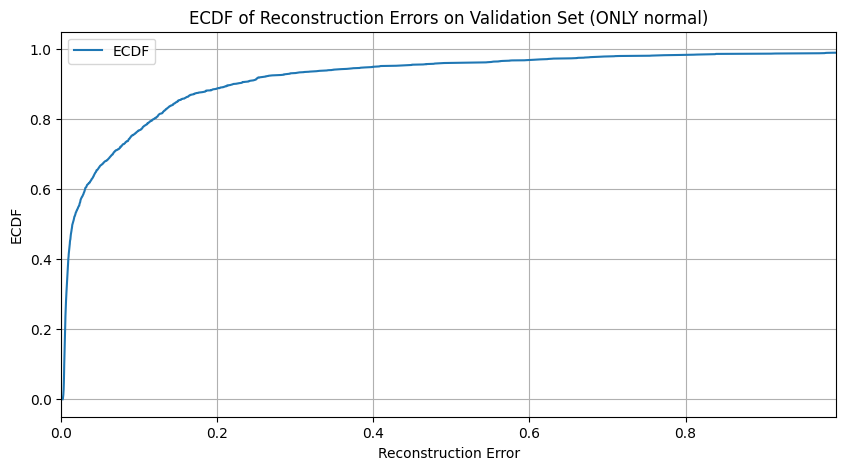

Since we trained on normal data, and since we are estimating using a NORMAL data validation set, we want a threshold that is almost the maximum reconstruction error, for example, a possible threshold can be the 95th percentile of NORMAL validation set: 0.4012842655181874


In [950]:
X_val_tensor = torch.tensor(X_val_normal.values, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    X_val_recon = model(X_val_tensor)
    reconstruction_errors = torch.zeros(X_val_tensor.shape[0], device=device)
    mse = torch.mean((X_val_tensor[:, numerical_idx] - X_val_recon[:, numerical_idx]) ** 2, dim=1)
    for start, end in categorical_dims:
        x_cat = X_val_tensor[:, start:end]
        x_recon_cat = X_val_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')
        reconstruction_errors += ce
    reconstruction_errors += mse
    reconstruction_errors = reconstruction_errors.cpu().numpy()

# Plot ECDF of reconstruction errors
sorted_errors = np.sort(reconstruction_errors)
ecdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf, label='ECDF')
plt.xlim(0, np.percentile(sorted_errors, 99))  # Limit x-axis to 99th percentile for better focus
plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF')
plt.title('ECDF of Reconstruction Errors on Validation Set (ONLY normal)')
plt.legend()
plt.grid(True)
plt.show()

threshold_val_normal_only = np.percentile(reconstruction_errors, 95)
print(f"Since we trained on normal data, and since we are estimating using a NORMAL data validation set, we want a threshold that is almost the maximum reconstruction error, for example, a possible threshold can be the 95th percentile of NORMAL validation set: {threshold_val_normal_only}")

## Optional evaluation

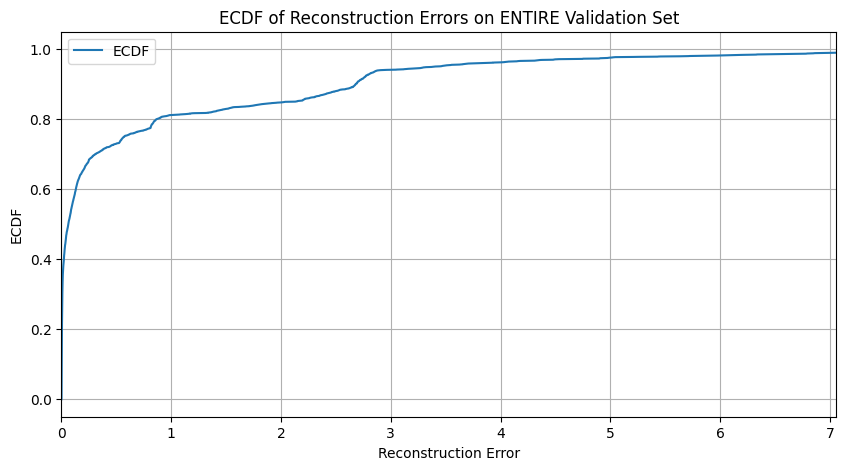


Percentile: 50th (Threshold = 0.0638) on entire validation set (normal + anomalies)
Average of Precision (Normal) and Recall (Anomaly): 0.9912
Average of F1 (Normal) and F1 (Anomaly): 0.7691

Percentile: 60th (Threshold = 0.1324) on entire validation set (normal + anomalies)
Average of Precision (Normal) and Recall (Anomaly): 0.9712
Average of F1 (Normal) and F1 (Anomaly): 0.8486

Percentile: 70th (Threshold = 0.3090) on entire validation set (normal + anomalies)
Average of Precision (Normal) and Recall (Anomaly): 0.9189
Average of F1 (Normal) and F1 (Anomaly): 0.9036

Percentile: 80th (Threshold = 0.8656) on entire validation set (normal + anomalies)
Average of Precision (Normal) and Recall (Anomaly): 0.7738
Average of F1 (Normal) and F1 (Anomaly): 0.8575

Percentile: 90th (Threshold = 2.6810) on entire validation set (normal + anomalies)
Average of Precision (Normal) and Recall (Anomaly): 0.5644
Average of F1 (Normal) and F1 (Anomaly): 0.6915

Percentile: 95th (Threshold = 3.3889) o

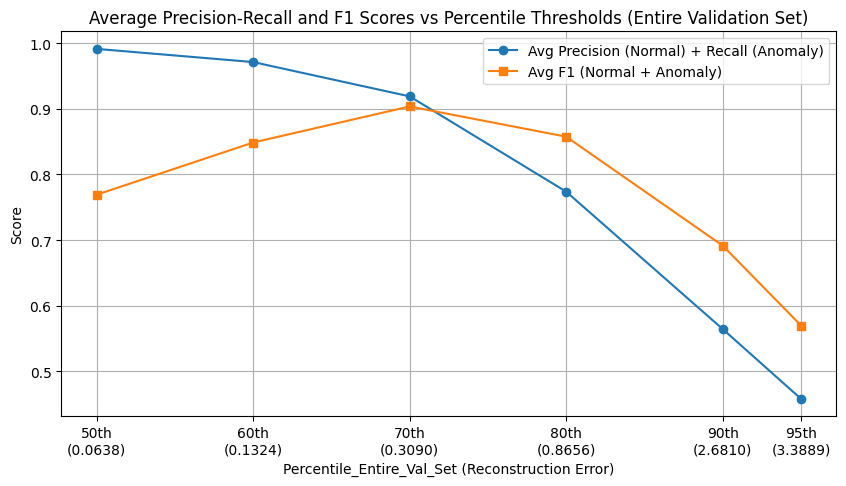


Selected Reconstruction Error Threshold (70th percentile of ENTIRE validation set): 0.3090
- We found that a high enough threshold (to avoid too many false alarms) with a low false benign rate is the 70th percentile.
- Since we trained on normal data only, we don't need an overly aggressive threshold. A moderate threshold like the 70th percentile of the entire validation set (normal + anomalies) minimizes false normal traffic predictions by focusing on high precision for normal and strong recall for anomalies. Since we want to avoid false benign traffic, we can look at the Average of Precision (Normal) and Recall (Anomaly), which for 70th percentile is: 0.9189
- But we need to consider how often the model wrongly classifies as anomaly to avoid too many false alarms, so we calculate the average of the previous score with the F1-avg score, which for 70th percentile is: 0.9112

- Hence, our previous estimation of 95th percentile of NORMAL validation set (0.4013), was a plausible threshol

In [951]:
# Use FULL validation set (normal + anomalies)
X_val_tensor = torch.tensor(df_val_preprocessed.drop(columns=['label', 'binary_label']).values, dtype=torch.float32).to(device)
y_val = df_val_preprocessed['binary_label'].values

model.eval()
with torch.no_grad():
    X_val_recon = model(X_val_tensor)
    reconstruction_errors = torch.zeros(X_val_tensor.shape[0], device=device)
    mse = torch.mean((X_val_tensor[:, numerical_idx] - X_val_recon[:, numerical_idx]) ** 2, dim=1)
    for start, end in categorical_dims:
        x_cat = X_val_tensor[:, start:end]
        x_recon_cat = X_val_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')
        reconstruction_errors += ce
    reconstruction_errors += mse
    reconstruction_errors = reconstruction_errors.cpu().numpy()

sorted_errors = np.sort(reconstruction_errors)
ecdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf, label='ECDF')
plt.xlim(0, np.percentile(sorted_errors, 99))  # Limit x-axis to 99th percentile for better focus
plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF')
plt.title('ECDF of Reconstruction Errors on ENTIRE Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# Test various percentile thresholds
percentiles = [50, 60, 70, 80, 90, 95]
avg_precision_recall_scores = []
avg_f1_scores = []
thresholds = []

for percentile in percentiles:
    threshold = np.percentile(reconstruction_errors, percentile)
    y_pred = (reconstruction_errors > threshold).astype(int)

    # Calculate metrics
    precision_normal = precision_score(y_val, y_pred, pos_label=0)
    recall_anomaly = recall_score(y_val, y_pred, pos_label=1)
    avg_precision_recall = (precision_normal + recall_anomaly) / 2

    f1_normal = f1_score(y_val, y_pred, pos_label=0)
    f1_anomaly = f1_score(y_val, y_pred, pos_label=1)
    avg_f1 = (f1_normal + f1_anomaly) / 2

    avg_precision_recall_scores.append(avg_precision_recall)
    avg_f1_scores.append(avg_f1)
    thresholds.append(threshold)

    print(f"\nPercentile: {percentile}th (Threshold = {threshold:.4f}) on entire validation set (normal + anomalies)")
    print(f"Average of Precision (Normal) and Recall (Anomaly): {avg_precision_recall:.4f}")
    print(f"Average of F1 (Normal) and F1 (Anomaly): {avg_f1:.4f}")

# Plot avg_precision_recall and avg_f1 vs percentiles in a single plot
plt.figure(figsize=(10, 5))
plt.plot(percentiles, avg_precision_recall_scores, marker='o', label='Avg Precision (Normal) + Recall (Anomaly)')
plt.plot(percentiles, avg_f1_scores, marker='s', label='Avg F1 (Normal + Anomaly)')
plt.xlabel('Percentile_Entire_Val_Set (Reconstruction Error)')
plt.ylabel('Score')
plt.title('Average Precision-Recall and F1 Scores vs Percentile Thresholds (Entire Validation Set)')
plt.xticks(percentiles, [f"{p}th\n({t:.4f})" for p, t in zip(percentiles, thresholds)])  # Show percentile and threshold
plt.legend()
plt.grid(True)
plt.show()

# Select the 70th percentile as the final threshold
threshold = np.percentile(reconstruction_errors, 70)
print(f"\nSelected Reconstruction Error Threshold (70th percentile of ENTIRE validation set): {threshold:.4f}")
print(f"- We found that a high enough threshold (to avoid too many false alarms) with a low false benign rate is the 70th percentile.")
print(f"- Since we trained on normal data only, we don't need an overly aggressive threshold. A moderate threshold like the 70th percentile of the entire validation set (normal + anomalies) minimizes false normal traffic predictions by focusing on high precision for normal and strong recall for anomalies. Since we want to avoid false benign traffic, we can look at the Average of Precision (Normal) and Recall (Anomaly), which for 70th percentile is: {avg_precision_recall_scores[percentiles.index(70)]:.4f}")
print(f"- But we need to consider how often the model wrongly classifies as anomaly to avoid too many false alarms, so we calculate the average of the previous score with the F1-avg score, which for 70th percentile is: {(avg_precision_recall_scores[percentiles.index(70)] + avg_f1_scores[percentiles.index(70)]) / 2:.4f}")

print(f"\n- Hence, our previous estimation of 95th percentile of NORMAL validation set ({threshold_val_normal_only:.4f}), was a plausible threshold.")

## Anomaly Detection with reconstruction error

### Testing on validation set (normal only)

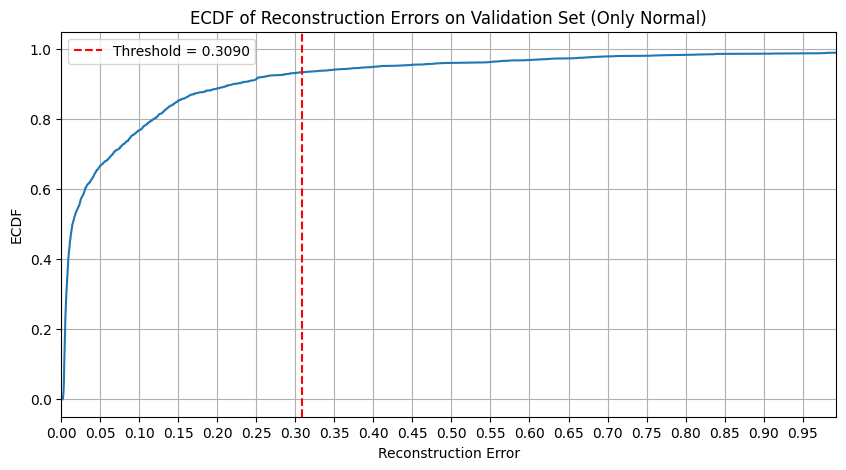

Mean value of reconstruction errors on (only normal) validation set: 0.2081


In [952]:
#Test the Model with ONLY normal validation set

X_val_tensor = torch.tensor(X_val_normal.values, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    X_val_recon = model(X_val_tensor)
    reconstruction_errors = torch.zeros(X_val_tensor.shape[0], device=device)
    mse = torch.mean((X_val_tensor[:, numerical_idx] - X_val_recon[:, numerical_idx]) ** 2, dim=1)
    for start, end in categorical_dims:
        x_cat = X_val_tensor[:, start:end]
        x_recon_cat = X_val_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')
        reconstruction_errors += ce
    reconstruction_errors += mse
    reconstruction_errors = reconstruction_errors.cpu().numpy()

y_pred_val = (reconstruction_errors > threshold).astype(int)

# Plot ECDF of reconstruction errors
# Plot ECDF of reconstruction errors with a moderate number of x-axis ticks
sorted_errors = np.sort(reconstruction_errors)
ecdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf)
plt.xlim(0, np.percentile(sorted_errors, 99))  # Limit x-axis to 99th percentile for better focus
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')  # Add threshold line
plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF')
plt.title('ECDF of Reconstruction Errors on Validation Set (Only Normal)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=False, nbins=24))  # Moderate number of ticks
plt.show()

print(f"Mean value of reconstruction errors on (only normal) validation set: {np.mean(reconstruction_errors):.4f}")

### Testing on the full train set

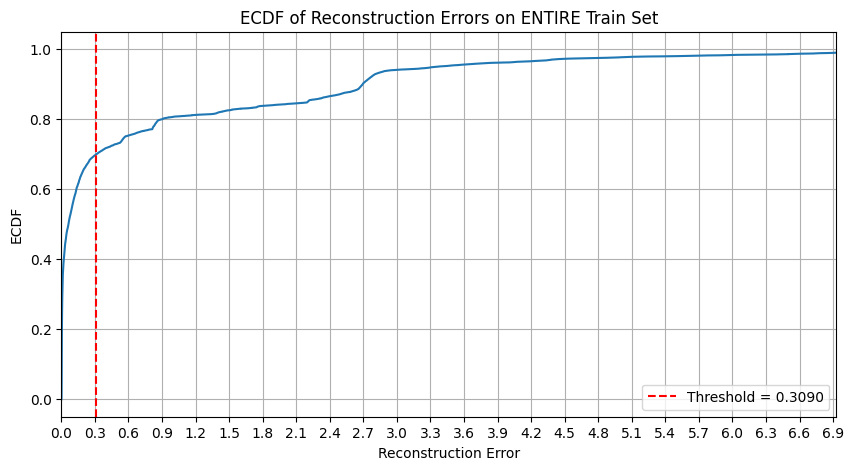

Mean value of reconstruction errors on ENTIRE train set: 0.7250


In [953]:
#Test the Model with ENTIRE train 
X_train_tensor = torch.tensor(df_train_preprocessed.drop(columns=['label', 'binary_label']).values, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    X_train_recon = model(X_train_tensor)
    reconstruction_errors = torch.zeros(X_train_tensor.shape[0], device=device)
    mse = torch.mean((X_train_tensor[:, numerical_idx] - X_train_recon[:, numerical_idx]) ** 2, dim=1)
    for start, end in categorical_dims:
        x_cat = X_train_tensor[:, start:end]
        x_recon_cat = X_train_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')
        reconstruction_errors += ce
    reconstruction_errors += mse
    reconstruction_errors = reconstruction_errors.cpu().numpy()

y_pred_train = (reconstruction_errors > threshold).astype(int)

# Plot ECDF of reconstruction errors with a moderate number of x-axis ticks
sorted_errors = np.sort(reconstruction_errors)
ecdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf)
plt.xlim(0, np.percentile(sorted_errors, 99))  # Limit x-axis to 99th percentile for better focus
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')  # Add threshold line
plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF')
plt.title('ECDF of Reconstruction Errors on ENTIRE Train Set')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=False, nbins=24))  # Moderate number of ticks
plt.show()

print(f"Mean value of reconstruction errors on ENTIRE train set: {np.mean(reconstruction_errors):.4f}")

### Testing on the test set

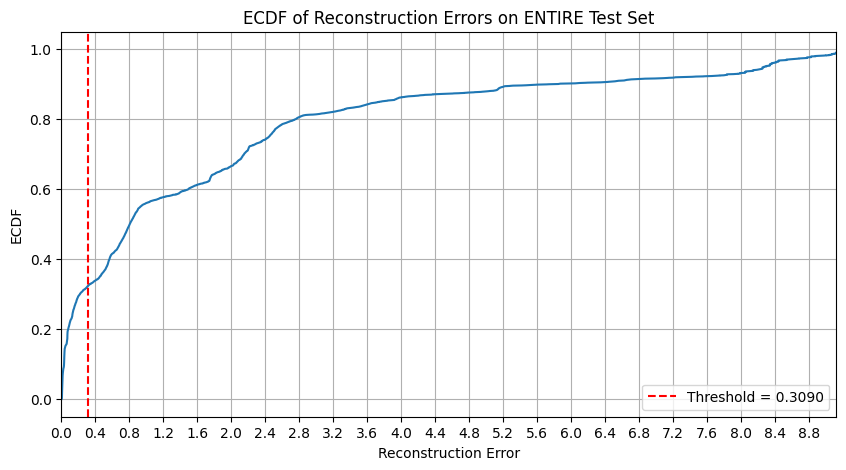

Mean value of reconstruction errors on ENTIRE test set: 1.9379

The validation set has smaller reconstruction errors because right now we have a set that contains only normal traffic.
Train set contains both normal and anomalous traffic so it has higher reconstruction errors.
Test set not only contains both normal and anomalous traffic but it must have a different kind of traffic (domain shift).


In [954]:
#Test the Model with ENTIRE test set
X_test_tensor = torch.tensor(df_test_preprocessed.drop(columns=['label', 'binary_label']).values, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    X_test_recon = model(X_test_tensor)
    reconstruction_errors = torch.zeros(X_test_tensor.shape[0], device=device)
    mse = torch.mean((X_test_tensor[:, numerical_idx] - X_test_recon[:, numerical_idx]) ** 2, dim=1)
    for start, end in categorical_dims:
        x_cat = X_test_tensor[:, start:end]
        x_recon_cat = X_test_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')
        reconstruction_errors += ce
    reconstruction_errors += mse
    reconstruction_errors = reconstruction_errors.cpu().numpy()

y_pred_test = (reconstruction_errors > threshold).astype(int)

# Calculate metrics for test set
precision_normal_test = precision_score(y_test, y_pred_test, pos_label=0)
recall_anomaly_test = recall_score(y_test, y_pred_test, pos_label=1)
avg_precision_recall_test = (precision_normal_test + recall_anomaly_test) / 2
f1_normal_test = f1_score(y_test, y_pred_test, pos_label=0)
f1_anomaly_test = f1_score(y_test, y_pred_test, pos_label=1)
avg_f1_test = (f1_normal_test + f1_anomaly_test) / 2

# Plot ECDF of reconstruction errors with a moderate number of x-axis ticks
sorted_errors = np.sort(reconstruction_errors)
ecdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, ecdf)
plt.xlim(0, np.percentile(sorted_errors, 99))  # Limit x-axis to 99th percentile for better focus
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')  # Add threshold line
plt.xlabel('Reconstruction Error')
plt.ylabel('ECDF')
plt.title('ECDF of Reconstruction Errors on ENTIRE Test Set')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=False, nbins=24))  # Moderate number of ticks
plt.show()

print(f"Mean value of reconstruction errors on ENTIRE test set: {np.mean(reconstruction_errors):.4f}")

print(f"\nThe validation set has smaller reconstruction errors because right now we have a set that contains only normal traffic.\n"
      f"Train set contains both normal and anomalous traffic so it has higher reconstruction errors.\n"
      f"Test set not only contains both normal and anomalous traffic but it must have a different kind of traffic (domain shift).")

### Confusion matrix full test set

Average of Precision (Normal) and Recall (Anomaly): 0.7658
Average of F1 (Normal) and F1 (Anomaly): 0.7270

Classification Report (Encoder + ReconstructionErrorThresh vs Ground Truth):
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2152
           1       0.78      0.84      0.81      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.72      0.73      5826
weighted avg       0.75      0.75      0.75      5826



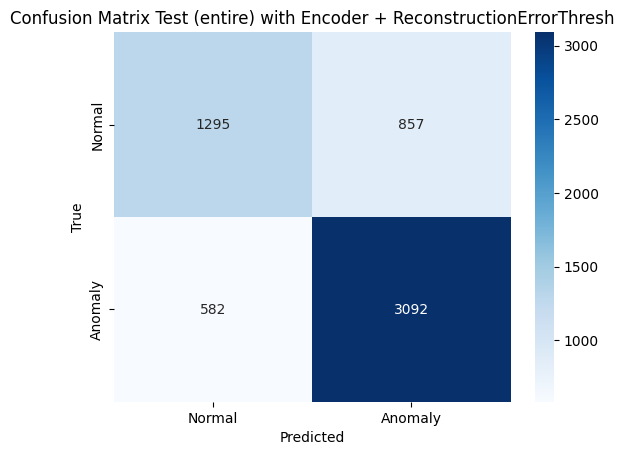

In [955]:
#plot_confusion_matrix(y_train, y_pred_train, "Encoder + ReconstructionErrorThresh", "Train (entire)")
#print("----------------------------------------------------------------------------------")

print(f"Average of Precision (Normal) and Recall (Anomaly): {avg_precision_recall_test:.4f}")
print(f"Average of F1 (Normal) and F1 (Anomaly): {avg_f1_test:.4f}")
plot_confusion_matrix(y_test, y_pred_test, "Encoder + ReconstructionErrorThresh", "Test (entire)")

## Auto-Encoder’s bottleneck and OC-SVM


Classification Report (OC-SVM on Bottleneck Embeddings vs Ground Truth vs Ground Truth):
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2152
           1       0.81      0.80      0.80      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.74      0.74      5826
weighted avg       0.75      0.75      0.75      5826



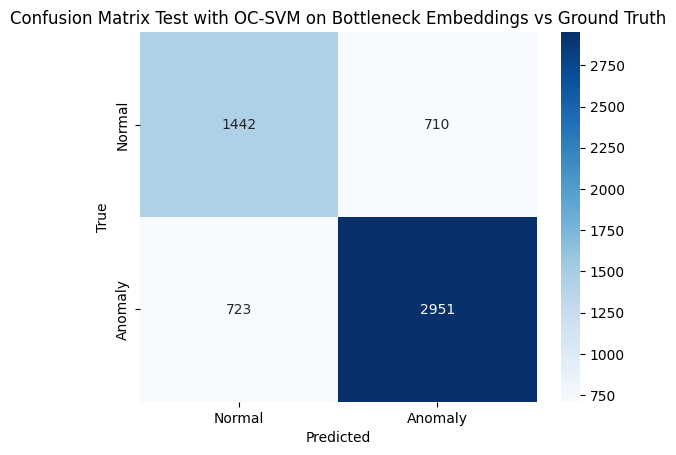

Average of Precision (Normal) and Recall (Anomaly): 0.7346
Average of F1 (Normal) and F1 (Anomaly): 0.7363


In [956]:
# Define function to extract bottleneck embeddings
def get_bottleneck_embeddings(model, data_tensor):
    model.eval()
    with torch.no_grad():
        embeddings = model.encoder(data_tensor).cpu().numpy()
    return embeddings

# Extract bottleneck embeddings for normal training data
X_train_normal_tensor = torch.tensor(df_train_preprocessed[df_train_preprocessed['binary_label'] == 0].drop(columns=['label', 'binary_label']).values, dtype=torch.float32).to(device)
X_train_embeddings = get_bottleneck_embeddings(model, X_train_normal_tensor)

# Train OC-SVM on bottleneck embeddings of normal data
ocsvm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.001)  # same param as task 2 for normal only
ocsvm.fit(X_train_embeddings)

# Extract bottleneck embeddings for test set
X_test_tensor = torch.tensor(df_test_preprocessed.drop(columns=['label', 'binary_label']).values, dtype=torch.float32).to(device)
X_test_embeddings = get_bottleneck_embeddings(model, X_test_tensor)
y_test = df_test_preprocessed['binary_label'].values

# Predict using OC-SVM on test set
y_test_pred = ocsvm.predict(X_test_embeddings)
y_test_pred_binary = (y_test_pred == -1).astype(int)

# Calculate metrics for test set
precision_normal_test = precision_score(y_test, y_test_pred_binary, pos_label=0)
recall_anomaly_test = recall_score(y_test, y_test_pred_binary, pos_label=1)
avg_precision_recall_test = (precision_normal_test + recall_anomaly_test) / 2

f1_normal_test = f1_score(y_test, y_test_pred_binary, pos_label=0)
f1_anomaly_test = f1_score(y_test, y_test_pred_binary, pos_label=1)
avg_f1_test = (f1_normal_test + f1_anomaly_test) / 2

# Print classification report and metrics for test set
plot_confusion_matrix(y_test, y_test_pred_binary, "OC-SVM on Bottleneck Embeddings vs Ground Truth", "Test")
print(f"Average of Precision (Normal) and Recall (Anomaly): {avg_precision_recall_test:.4f}")
print(f"Average of F1 (Normal) and F1 (Anomaly): {avg_f1_test:.4f}")


## PCA and OC-SVM

### PCA Analysis to Find Elbow Point

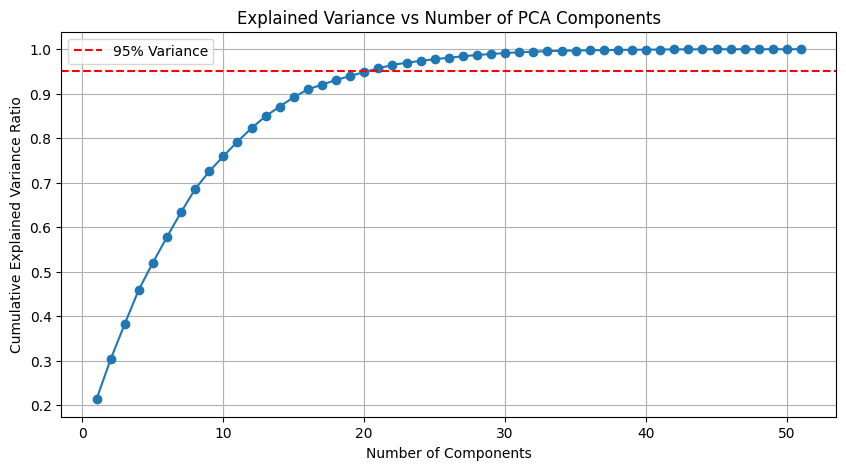

Selected number of PCA components (explaining ~95% variance): 21


In [957]:
# Extract normal training data
X_train_normal = df_train_preprocessed[df_train_preprocessed['binary_label'] == 0].drop(columns=['label', 'binary_label'])

# PCA Analysis to Find Elbow Point
# Fit PCA on normal training data
pca = PCA()
pca.fit(X_train_normal)

# Calculate cumulative explained variance:
# pca.explained_variance_ratio_[i] is the fraction of total variance
# captured by the i‑th principal component (components are ordered by descending variance).
# np.cumsum(...) then gives, for k=1,2,…, the cumulative variance explained by the first k components.
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance to find elbow point
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of PCA Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Find elbow point (number of components explaining ~95% variance)
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Selected number of PCA components (explaining ~95% variance): {n_components}")

### Fit and Transform on normal train set and trasform the test set

In [958]:
# Fit and Transform Normal Training Data, Transform Test Data
# Fit PCA with selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_normal)

# Transform test set
X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])
X_test_pca = pca.transform(X_test)
y_test = df_test_preprocessed['binary_label'].values

### Train OC-SVM


Classification Report (OC-SVM on PCA Components vs Ground Truth) on Test Set:
              precision    recall  f1-score   support

      Normal       0.66      0.77      0.71      2152
     Anomaly       0.85      0.77      0.81      3674

    accuracy                           0.77      5826
   macro avg       0.76      0.77      0.76      5826
weighted avg       0.78      0.77      0.77      5826

Average of Precision (Normal) and Recall (Anomaly): 0.7176
Average of F1 (Normal) and F1 (Anomaly): 0.7609


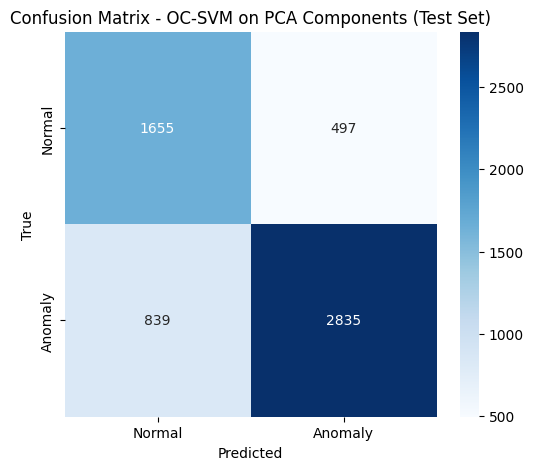

In [959]:
# Train OC-SVM on PCA Components of Normal Data
ocsvm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.001)     # using values used in task 2 for normal only
ocsvm.fit(X_train_pca)

# Evaluate OC-SVM on Test Set
y_test_pred = ocsvm.predict(X_test_pca)
y_test_pred_binary = (y_test_pred == -1).astype(int)  # Convert -1 (anomaly) to 1, 1 (normal) to 0

# Calculate metrics
precision_normal = precision_score(y_test, y_test_pred_binary, pos_label=0)
recall_anomaly = recall_score(y_test, y_test_pred_binary, pos_label=1)
avg_precision_recall = (precision_normal + recall_anomaly) / 2

f1_normal = f1_score(y_test, y_test_pred_binary, pos_label=0)
f1_anomaly = f1_score(y_test, y_test_pred_binary, pos_label=1)
avg_f1 = (f1_normal + f1_anomaly) / 2

# Print classification report and metrics
print("\nClassification Report (OC-SVM on PCA Components vs Ground Truth) on Test Set:")
print(classification_report(y_test, y_test_pred_binary, target_names=['Normal', 'Anomaly']))
print(f"Average of Precision (Normal) and Recall (Anomaly): {avg_precision_recall:.4f}")
print(f"Average of F1 (Normal) and F1 (Anomaly): {avg_f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - OC-SVM on PCA Components (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Task 4: Unsupervised Anomaly Detection and Interpretation

In [34]:
# Set seeds
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [35]:
def compute_sse(X, centroids, labels):
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values

def plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels):

    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1

    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    plt.close()
    return

def plot_tsne(df, perplexity, lbls):
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df.drop(columns=['label','binary_label','cluster_label']))
    labels = list(df[lbls])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()

    return

## K-means with little domain knowledge

In [36]:
X_train = df_train_preprocessed.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train_preprocessed['label'])
y_train = list(df_train_preprocessed['binary_label'])

# non so che dataset usare :)
#df_preprocessed = pd.concat([df_train_preprocessed, df_val_preprocessed], axis=0, ignore_index=True)
#X_train = df_preprocessed.drop(columns=['label', 'binary_label'])
#y_original_train = list(df_preprocessed['label'])
#y_train = list(df_preprocessed['binary_label'])

# Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia
kmeans = KMeans(n_clusters=4, n_init=50)
kmeans_labels = kmeans.fit_predict(X_train)
kmeans_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

## K-means cluster interpretation

K-Means SSE: 338638.16
K-Means Silhouette Score: 0.46
For n_clusters = 4 The average silhouette_score is : 0.4631150785092281
cluster 0 size 12110
cluster 1 size 1522
cluster 2 size 7
cluster 3 size 1425


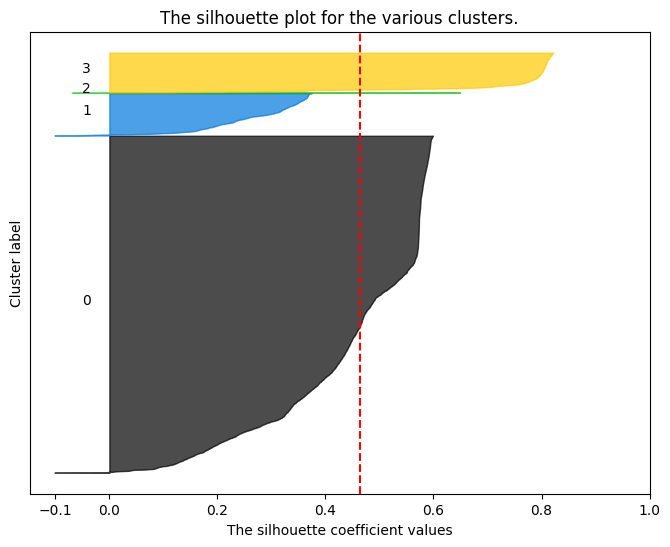

Silhouette Score
Cluster                  
0                  0.4543
1                  0.2666
2                  0.4766
3                  0.7482

col_0   dos  normal  probe   r2l
row_0                           
0      0.06    0.85   0.08  0.01
1      0.17    0.29   0.54  0.00
2      0.00    1.00   0.00  0.00
3      0.93    0.02   0.05  0.00

col_0   dos  normal  probe  r2l
row_0                          
0       736   10287    943  144
1       264     435    823    0
2         0       7      0    0
3      1330      29     65    1

In [37]:
print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels)

sil_df = pd.Series(clusters_silhouettes, name="Silhouette Score").round(4).rename_axis("Cluster").to_frame()
display(sil_df)

label_distribution = pd.crosstab(kmeans_labels, y_original_train, normalize="index").round(2)
display(label_distribution)

label_distribution_number = pd.crosstab(kmeans_labels, y_original_train).round(2)
display(label_distribution_number)

### Use the t-SNE algorithm to obtain a 2D visualization of your points

Perplexity: 10


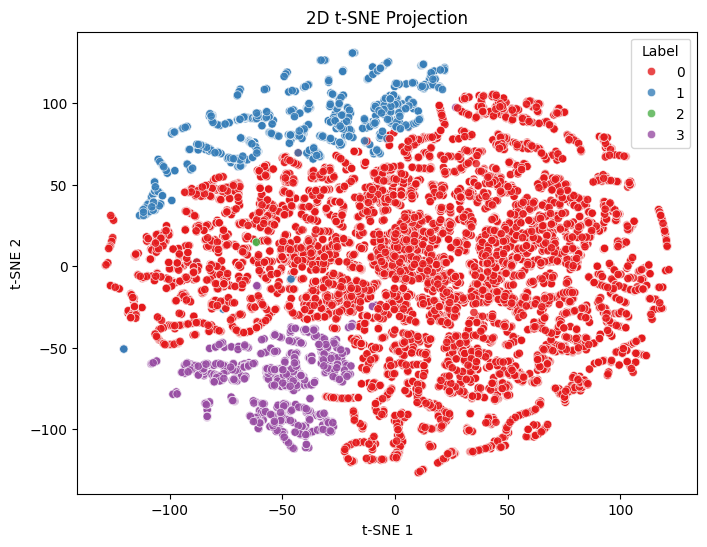

Perplexity: 25


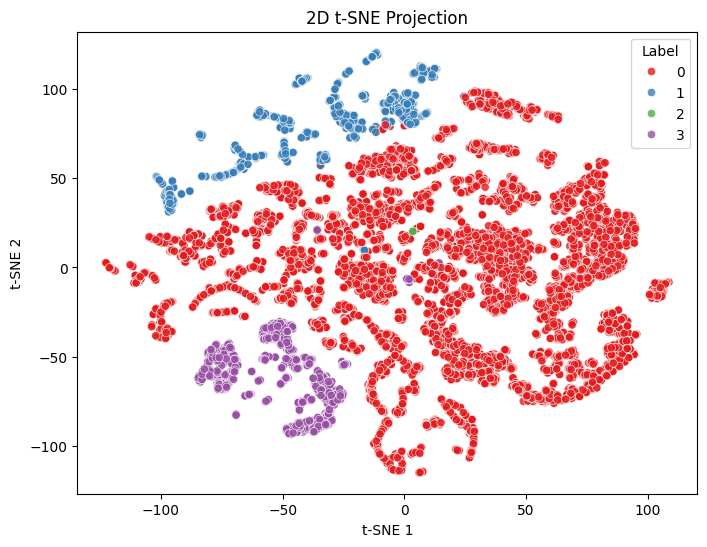

Perplexity: 40


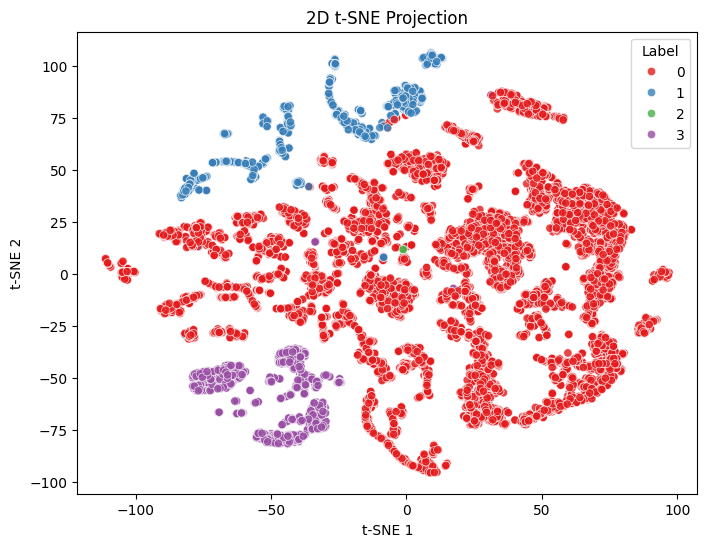

In [38]:
df_clusters = pd.DataFrame(X_train.copy())
df_clusters["cluster_label"] = kmeans_labels
df_clusters["label"] = y_original_train
df_clusters["binary_label"] = y_train

for perplexity in [10, 25, 40]:
    print(f"Perplexity: {perplexity}")
    plot_tsne(df_clusters, perplexity, 'cluster_label')

Perplexity 25


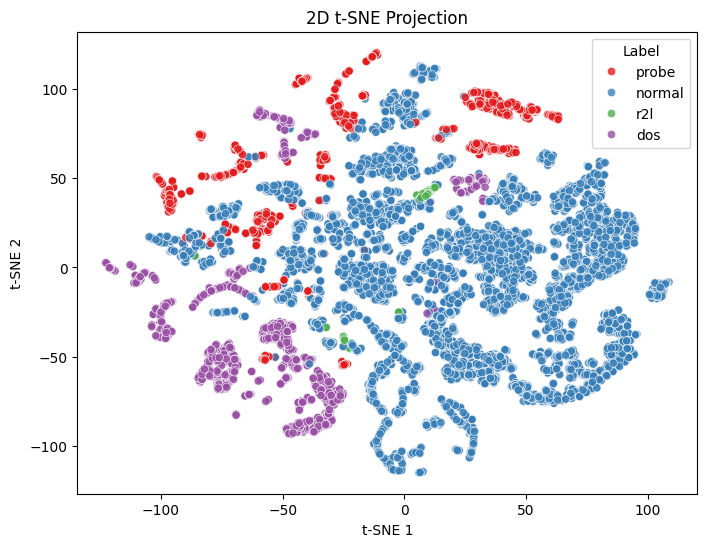

In [39]:
print(f"Perplexity 25")
plot_tsne(df_clusters, 25, 'label')

## DB-Scan anomalies are anomalies?

### Estimate min points

In [40]:
# The smallest cluster that consists only of normal data is the cluster 3 which contains 7 normal points
min_points = 7  # estimate

### Estimate epsilon

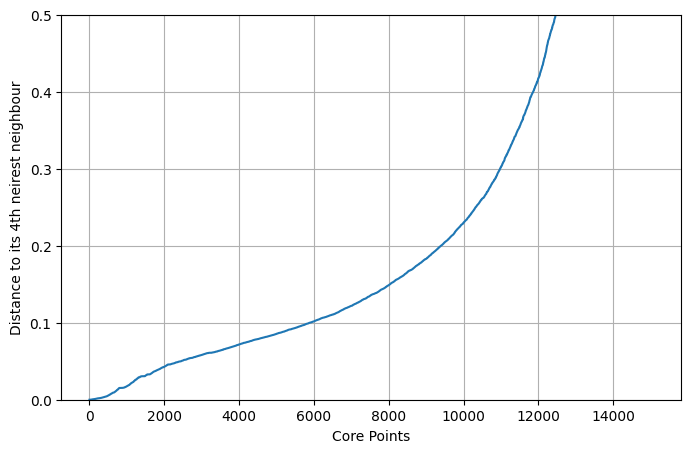

In [41]:
#  K-distance elbow plot per eps
num_neighbors = 4
nn = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto', n_jobs=-1)
nn.fit(X_train)

# Compute distances to n nearest neighbors (including the point itself)
distances, _ = nn.kneighbors(X_train)

# Distance to the 4th nearest neighbor (not counting self, which is at index 0)
nth_neighbor_distances = distances[:, num_neighbors-1]  # n th closest = n-1 th real neighbor
# Now fourth_neighbor_distances[i] gives you the distance of point i to its 4th neighbor

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(sorted(nth_neighbor_distances))  ## Sorted in ascending order
plt.xlabel('Core Points')
plt.ylabel('Distance to its 4th neirest neighbour')
plt.ylim(0,0.5)
plt.grid(True)
plt.show()
plt.close()

# epsilon is estimated using the elbow rule, e = 0.15

### Create clustering results

In [42]:
# Use DBSCAN with the epsilon and min_points previosly defined
dbscan = DBSCAN(eps=0.15, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train)  # -1 is noise cluster - 0,1,2 are the other clusters

In [43]:
# dbscan_labels == -1 is True for every point DBSCAN classified as noise and False for every point in a cluster.
table = pd.crosstab(dbscan_labels == -1, y_original_train, normalize="index")
print(f"Noise cluster:\n{table}")
# about 70% of points flagged as noise are normal so dbscan has poor performance in this case

Noise cluster:
col_0       dos    normal     probe       r2l
row_0                                        
False  0.165857  0.738831  0.084810  0.010503
True   0.146459  0.696028  0.148532  0.008981


In [44]:
df_clusters = pd.DataFrame({
    'cluster_label': dbscan_labels,
    'label': y_original_train,
    'binary_label': y_train
})

df_clusters = df_clusters[df_clusters['cluster_label'] != -1]  # Filters -1 cluster
top10 = df_clusters['cluster_label'].value_counts().nlargest(10).index  # Find the 10 largest clusters
df_top10 = df_clusters[df_clusters['cluster_label'].isin(top10)]  # Keep only top 10 clusters

dist_table = pd.crosstab(df_top10['cluster_label'], df_top10['label'], normalize="index").round(3)

print("Label distribution per DBSCAN cluster:")
print(dist_table)

Label distribution per DBSCAN cluster:
label          dos  normal  probe
cluster_label                    
0              0.0     0.0    1.0
1              0.0     1.0    0.0
3              0.0     1.0    0.0
4              0.0     1.0    0.0
6              1.0     0.0    0.0
8              0.0     1.0    0.0
9              1.0     0.0    0.0
11             1.0     0.0    0.0
20             0.0     1.0    0.0
28             1.0     0.0    0.0


### Use the t-SNE for visualization

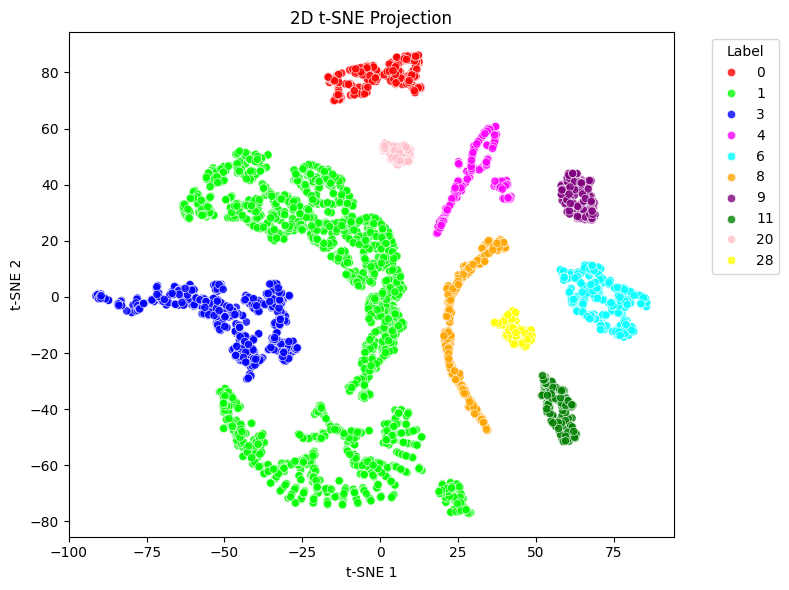

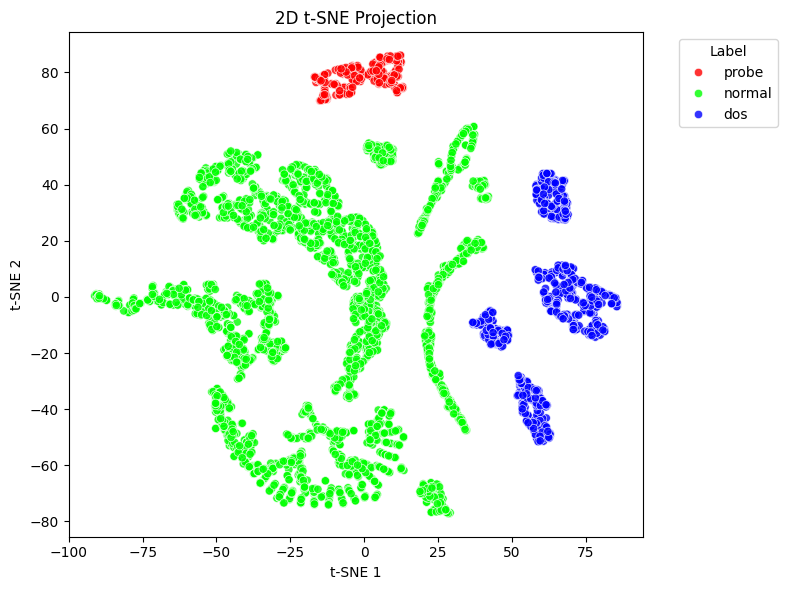

In [ ]:
df_vis = X_train.copy()
df_vis['cluster_label'] = dbscan_labels
df_vis['label']         = y_original_train
df_vis['binary_label']  = y_train

df_vis = df_vis[df_vis['cluster_label'].isin(top10)].copy()  # Keep only top 10 clusters

def plot_tsne(df, perplexity, lbls):    # updated function because otherwise we would have same color sometimes
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df.drop(columns=['label', 'binary_label', 'cluster_label']))
    labels = list(df[lbls])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    unique_labels = np.unique(labels)
    n_colors = len(unique_labels)
    
    if n_colors <= 10:
        palette = [
            '#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF', 
            '#FFA500', '#800080', '#008000', '#FFC0CB', '#FFFF00'
        ][:n_colors]
    else:
        cmap = plt.cm.get_cmap('hsv', n_colors)
        palette = [cmap(i) for i in range(n_colors)]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, 
        x='TSNE1', 
        y='TSNE2',
        hue='label', 
        palette=palette, 
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return

# Plot using cluster labels
plot_tsne(df_vis, perplexity=25, lbls='cluster_label')

# Plot using attack labels
plot_tsne(df_vis, perplexity=25, lbls='label')